Railway Knowledge System
===

Ren Nakagawa

---

## Components
- GPT4o - mini
- ReAct
  - RAG with fasis (鉄道に関する技術上の基準を定める省令)
  - RAG with fasis (鉄道事故報告書)
  - Code Interpleter(Math Calculator)
  - Text Exstractor
  - Search with duckduckgo

In [1]:
IS_ALL_RUN = True

# Set up

In [2]:
!git clone https://github.com/rakawanegan/pbl-railway-knowledge-system
%cd pbl-railway-knowledge-system
%pip uninstall torch torchvision torchaudio -y
%pip install -r requirements.txt >> install.txt

Cloning into 'pbl-railway-knowledge-system'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 445 (delta 10), reused 18 (delta 6), pack-reused 418 (from 1)
Receiving objects: 100% (445/445), 6.72 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (210/210), done.
/content/pbl-railway-knowledge-system
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 re

In [4]:
import os
import time
import pandas as pd
from tqdm import tqdm
from contextlib import contextmanager
from google.colab import userdata
from langchain_openai import ChatOpenAI

from src.tool_component import tool_usage_tracker, MakeRailwayKnowledgePrompt
from src.utils import load_criteria_with_weights, get_rel_config_path
from src.main import make_agent, evaluate_by_llm_with_criteria, plot_tools_count

In [5]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY') # Set up OpenAI API key
k = 3
p_tool_configs, p_eval_configs, p_react_prompt = get_rel_config_path()
print(f"p_tool_configs: {p_tool_configs}")
print(f"p_eval_configs: {p_eval_configs}")
print(f"p_react_prompt: {p_react_prompt}")
mrkp = MakeRailwayKnowledgePrompt(k=k)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = make_agent(p_tool_configs, p_react_prompt, k, llm)
criteria_with_weights = load_criteria_with_weights(p_eval_configs)

p_tool_configs: ['./docs/tools/code.yaml', './docs/tools/incident_rag.yaml', './docs/tools/knowledge_rag.yaml', './docs/tools/raw_text.yaml', './docs/tools/search.yaml', './docs/tools/wikipedia.yaml']
p_eval_configs: ['./docs/evals/accuracy.yaml', './docs/evals/calculation.yaml', './docs/evals/evidence.yaml', './docs/evals/expertise.yaml', './docs/evals/expression.yaml', './docs/evals/relevance.yaml']
p_react_prompt: ./docs/react_base_prompt.md


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/content/pbl-railway-knowledge-system/src/main.py:30: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built 

In [6]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

def react_inference(question):
    try:
        output = agent.run(question)
    except Exception as e:
        output = f"Error: {e}"
    return output

def rag_inference(question):
    try:
        prompt = mrkp.make_prompt(question)
        output = llm.predict(prompt)
    except Exception as e:
        output = f"Error: {e}"
    return output

# Main

In [7]:
df = pd.read_csv("data/Question.csv")
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if not IS_ALL_RUN:
        break
    row = dict(row)
    query = row["問題"]
    answer = row["答え"]
    react_predict = react_inference(query)
    rag_predict = rag_inference(query)
    react_eval_score = evaluate_by_llm_with_criteria(
        pred=react_predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )['final_score']
    rag_eval_score = evaluate_by_llm_with_criteria(
        pred=rag_predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )['final_score']
    dict_eval = {
        "react_predict": react_predict,
        "rag_predict": rag_predict,
        "react_eval_score": react_eval_score,
        "rag_eval_score": rag_eval_score,
    }
    row.update(dict_eval)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/Compare_Answer.csv", index=False)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-6-e29a0680e6d7>:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = agent.run(question)




> Entering new AgentExecutor chain...
この文は、鉄道事業者が省令に基づいて具体的な基準やガイドラインを策定することを示しています。空欄に入る適切な言葉を見つけるために、鉄道に関連する技術基準や省令の内容を調べる必要があります。特に「詳細な」という形容詞が使われているため、具体的な基準や計画に関連する用語が適切でしょう。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「鉄道事業者 施設 車両 設計 維持管理 運行」  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧省令と異なる構造とすることとしたときの条件を考慮して、条件を付した基準とするなどの方法により、実施

<ipython-input-6-e29a0680e6d7>:17: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = llm.predict(prompt)
/content/pbl-railway-knowledge-system/src/main.py:98: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


評価プロセス:  1. 情報の読み込み:     - 解答：「実施基準」     - 採点対象：「実施基準」  2. 情報の比較:     - 解答と採点対象は完全に一致しており、重要な情報が全て記載されている。     - 不足情報や過剰情報はない。  3. 不足情報のリストアップ:     - 不足情報: なし     - 過剰情報: なし  4. 評価値の算出:     - 重要な情報が全て記載され、誤りもないため、評価は「5点」とする。  - 評価結果: 【5】点    - 理由: 重要な情報が全て記載されており、誤りが一切ないため。
【N/A】  理由: 問題には計算が含まれていないため、評価対象外とする。
評価プロセス:1. 情報の読み込み:   - 問題文: 「実施基準」   - 採点対象: 「実施基準」2. 根拠の特定と対応確認:   - 採点対象の「実施基準」は問題文の「実施基準」と完全に一致している。3. 具体性と信頼性の評価:   - 採点対象は問題文に対して直接的かつ具体的な回答を提供しており、信頼性も高い。4. 不要情報の確認:   - 採点対象には問題に関係のない情報は含まれていない。5. 評価値の算出:   - 根拠が問題に完全に関連しており、具体性と信頼性が非常に高いため、「5点」とする。評価結果: 【5】点  理由: 採点対象は問題に対して完全に関連し、具体的かつ信頼性が非常に高いため、最高評価を与えた。
評価結果: 【5】点  理由: 専門用語「実施基準」が正確に使用されており、文脈との整合性も完全であるため、評価は最高点となる。
【5】点  理由: 採点対象は非常に簡潔で論理的に構成されており、要点が明確に整理されているため、読みやすさに優れています。冗長な表現や読みにくい部分は見受けられず、全体として高い評価を得るに値します。
評価プロセス:1. 問題の要求の特定:     - 「実施基準」という具体的な用語を求めている。2. 採点対象の確認:     - 採点対象は「実施基準」となっており、問題文の要求に対して正確に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。評

  3%|▎         | 1/30 [00:40<19:29, 40.33s/it]

評価プロセス:1. 問題の要求の特定:     - 「実施基準」という具体的な用語を求めている。2. 採点対象の確認:     - 採点対象は「実施基準」となっており、問題文の要求に対して正確に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。評価結果:  【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この文は鉄道事業者が省令への適合を証明するための基準について述べています。空欄に入る適切な言葉を見つけるために、関連する技術基準や解釈基準を検索する必要があります。具体的には、鉄道に関する技術基準や解釈基準に関連するキーワードを使って検索を行います。

Action: RailwayTechnicalKeywordSearcher  
Action Input: "技術的実績 実証データ 客観的な検討方法"  
Observation: 実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
Thought:この文の空欄には「理論解析」が入ることが分かりました。これは、技術的実績や実証データに基づく客観的な検討方法の一つとして適切です。

Final Answer: 理論解析

> Finished chain.
評価プロセス:  1. 情報の読み込み:     - 解答：「理論解析」     - 採点対象：「理論解析」  2. 情報の比較:     - 解答に記載されている情報は、採点対象にも全て記載されている。     - 採点対象には過剰情報はない。  3. 不足情報のリストアップ:     - 不足情報: なし  4. 評価値の算出:     - 重要な情報が全て記載されており、誤りもないため、評価は「5点」とする。  評価結果: 【5】点  理由: 重要な情報が全て記載されており、誤り

  7%|▋         | 2/30 [01:19<18:27, 39.55s/it]

【4】点（問題文の要求を概ね満たしているが、具体的な文脈や詳細が不足しているため、軽微な不足がある。）


> Entering new AgentExecutor chain...
この質問は、新幹線の騒音に関する環境基準や音源対策についての情報を求めています。具体的には、音源対策が何の防止または軽減を図る上で基本的な施策であるかを知りたいと思います。関連する技術基準や環境基準を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 音源対策  

Observation: 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。
Thought:I now know the final answer.  
Final Answer: 音源対策が騒音の防止または軽減を図る上で最も基本的な施策である。

> Finished chain.
1. 情報の読み込み:     - 解答：「音源対策」「騒音の防止」「軽減」「基本的な施策」     - 採点対象：「音源対策」「騒音の防止または軽減」「基本的な施策」  2. 情報の比較:     - 採点対象は解答に含まれる重要な情報をほぼ全て記載しているが、「騒音」という単語のみが解答に記載されていない（不足情報）。     - 採点対象には過剰情報はない。  3. 不足情報のリストアップ:     - 不足情報: 「騒音」  4. 評価値の算出:     - 重要な情報の一部が欠けているため、評価は「3点」とする。  評価結果: 【3】点  理由: 「騒音」が不足しているが、誤りや過剰情報はない。
評価対象には計算が含まれていないため、本項目は評価対象外（N/A）となります。  評価結果: 【N/A】
評価プロセス:1. 情報の読み込み:   - 問題文: 「音源対策が騒音の防止または軽減を図る上で最も基本的な施策である。」   - 採

 10%|█         | 3/30 [02:03<18:46, 41.74s/it]

1. 問題の要求の特定:     - 問題文は「新幹線の騒音について」の内容を求めており、特に「騒音」に関する情報を抜き出すことが求められている。2. 採点対象の確認:     - 採点対象は「騒音」という単語のみであり、具体的な文脈や詳細が含まれていない。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して非常に限定的であり、騒音に関する具体的な情報や背景が全く示されていないため、不足と判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
鉄道事業者が策定する実施基準の内容には、技術的な要素や運行管理、保守点検、安全対策などが含まれるべきです。具体的な要素を把握するために、鉄道に関する技術基準を検索してみます。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「実施基準」  
Observation: 実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。 本線及び本線の電車線路は車両の所定の速度で安全に運転することができる状態に保持するため、線区の状況、列車の運行状況に応じて巡視すること。巡視の頻度や時期、方法などについては、状況に応じて定めること。 列車の検査は、事業者が車両の使用状況、設計方法、管理方法又は運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。
Thought:鉄道事業者が策定する実施基準には、技術的な要素や運行管理、保守点検、安全対策などが含まれるべきです。具体的には、以下のような要素が考えられます：

1. **技術基準**: 車両や設備の設計、製造、運用に関する基準。
2. **運行管理**: 列車の運行計画、ダイヤ管理、運行指令に関する基準。
3. **保守点検**: 車両やインフラの定期点検、保守作業の基準。
4. **安全対策**: 事故防止のための措置、緊急時の対応手順。
5. **巡視基準**: 線区の状況や列車

 13%|█▎        | 4/30 [03:51<29:25, 67.91s/it]

1. **役割**: 採点対象が問題の要求に沿った適切な内容となっているかを評価する役割です。2. **評価基準**: 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。3. **点数の目安**:    - 5点: 問題文の要求を完全に満たしており、内容が適切で正確である。   - 4点: 問題文の要求を概ね満たしているが、軽微な不足や誤りがある。   - 3点: 問題文の要求を部分的に満たしているが、不足や誤りが複数見られる。   - 2点: 問題文の要求に大きく逸脱しており、不足や誤りが多い。   - 1点: 問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している。4. **評価プロセス**:   - 問題文を読み込み、要求されている指示（例: 抜き出し、要約、考察）を特定する。   - 採点対象を読み込み、問題文の指示に従っているかを確認する。   - 採点対象の内容が要求に対して不足しているか、過剰であるか、または誤りがあるかを評価する。   - 問題の要求に基づいて適切な評価値をつける。5. **評価結果**:   - 採点対象は「実施基準には、解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な内容が求められる。」と述べており、問題文の要求に対して具体的な内容が不足しているため、部分的にしか満たしていないと判断されます。具体的な要素や詳細な内容が欠けているため、評価は「3点」とします。- 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
新幹線に関する騒音の環境基準について調べる必要があります。技術基準や関連する情報を検索するために、鉄道に関する技術基準を定めた省令から関連する文章を探すことが適切です。具体的には「新幹線 騒音 環境基準」というキーワードで検索します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 新幹線 騒音 環境基準  
Observation: ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構

 17%|█▋        | 5/30 [04:47<26:27, 63.49s/it]

1. 問題の要求の特定:     - 問題文は新幹線に関する騒音の環境基準についての要約を求めている。2. 採点対象の確認:     - 採点対象は「新幹線の騒音は、環境省の基準に基づき、音源対策により沿線の住宅の集合度合いに応じて75デシベル以下を目標としています。」という内容である。3. 不足や誤りの確認:     - 採点対象は新幹線の騒音基準についての要約を行っているが、具体的な内容（音源対策の重要性や住宅密集度に応じた段階的な実施など）が欠けているため、情報が不十分である。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な要素が不足しているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問に対しては、鉄道に関する技術基準を調べる必要があります。特に、騒音レベルに関連する基準を探すために、技術基準の文書を検索します。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 騒音レベル  
Observation: 普通鉄道(新幹線を除く。)の新設又は大規模改良に際しては、沿線屋外の地上 1.2 メートルの高さにおける近接側軌道中心線から水平距離が 12.5 メートルの地点において、次の騒音レベルとする。
新設は、等価騒音レベルとして、昼間(7 ~ 22 時)は 60 デシベル以下、夜間(22~翌7時)は55デシベル以下とする。
大規模改良は、騒音レベルの状況を改良前より改善する。
Thought:この情報から、普通鉄道の新設または大規模改良における騒音レベルの基準が明確になりました。具体的には、新設の場合、昼間は60デシベル以下、夜間は55デシベル以下と定められています。また、大規模改良の場合は、騒音レベルを改良前よりも改善することが求められています。

Final Answer: 普通鉄道の新設における騒音レベルの基準は、昼間（7時～22時）は60デシベル以下、夜間（22時～翌7時）は55デシベル以下とされています。大規模改良の場合は、騒音レベルを改良前より改善することが求められます。

> Finished chain.
1. 

 20%|██        | 6/30 [05:53<25:46, 64.46s/it]

1. **役割の評価**:     採点対象は、普通鉄道の新設または大規模改良における騒音レベルの基準についての情報を提供していますが、問題文の要求に対して具体的な基準値を示すことが求められています。採点対象は新設の場合の基準を示していますが、夜間の基準が55デシベル以下とされている点は誤りであり、また大規模改良に関する具体的な基準が不足しています。全体として、問題文の要求を部分的に満たしているが、不足や誤りが見られるため、評価は「3点」とします。- 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この文は鉄道に関する技術基準や規則に関連している可能性があります。「列車等を操縦する_____」の空欄に入る言葉を探すために、鉄道技術基準に関連する情報を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 列車 操縦  
Observation: 「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
- 列車等を操縦する係員
- 列車の運転順序変更、行き違い変更、運転の取消し等の運転整理を行う係員
- 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
- 列車等の進路制御、閉そく、鉄道信号の取扱い又は転てつ器の操作をする係員
- 線路、電車線路又は運転保安設備の保守、工事等で列車の運転に直接関係があるものを単独で行い、又は指揮監督する作業を行う係員
１(1)及び(3)の係員に対しては、乗務前、列車の運転中その他適当なときに運転上必要な事項について報告を求め、又は指示を与える等適切な監督ができる体制を整えておくこと。
第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員（本線を支障するおそれのない側線において移動する車両を操縦する係員を除く。６において同じ。）に対する酒気を帯びた状態の確認は、次のとおりとすること。
##2.2 第１１条（動力車を操縦する係員の乗務等）関係
第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、

 23%|██▎       | 7/30 [06:56<24:32, 64.00s/it]

1. 問題の要求の特定:     - 問題文は「列車等を操縦する係員は、次のとおりとすること。」という内容から、係員に関する具体的な情報を求めている。2. 採点対象の確認:     - 採点対象は「係員」という単語のみであり、具体的な内容や詳細が不足している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して非常に簡潔すぎて、具体的な情報や説明が全く含まれていないため、大きな不足があると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
この文は鉄道事業者における保守作業に関する規定の一部のようです。具体的な技術基準や関連する法令を探す必要があります。したがって、鉄道に関する技術基準を検索するために、関連するキーワードを使用して情報を取得します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「施設 車両 保守」  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧

 27%|██▋       | 8/30 [07:44<21:36, 58.93s/it]

評価プロセス:1. 問題の要求の特定:     - 「施設及び車両の保守その他これに類する作業を行う係員」という文から、関連する内容を抜き出すことが求められている。2. 採点対象の確認:     - 「作業」という単語のみが解答として挙げられているが、これは非常に抽象的であり、具体的な内容を示していない。3. 不足や誤りの確認:     - 解答は問題文の内容を正確に反映しておらず、具体性が欠けているため、不足と判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。評価結果:  【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）


> Entering new AgentExecutor chain...
この文は鉄道に関する技術基準の一部のようです。具体的な技術基準や関連する情報を探すために、キーワードを使って検索する必要があります。ここでは「第３項の知識及び技能」や「係員に対する確認」というフレーズが含まれているため、関連する技術基準を探すのが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「第３項 知識 技能 係員 確認」  
Observation: 実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
# 2. 係員
## 2.1 第１０条（係員の教育及び訓練等）関係
「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
- 列車等を操縦する係員
- 列車の運転順序変更、行き違い変更、運転の取消し等の運転整理を行う係員
- 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
- 列車等の進路制御、閉そく、鉄道信号の取扱い又は転てつ器の操作をする係員
- 線路、電車線路又は運転保安設備の保守、工事等で列車の運転に直接関係があるものを単独で行い、又は指揮監督する作業を行う係員
- 踏切保安設備を操作する係員
「施設及び車両の保守その他これに類する作

 30%|███       | 9/30 [08:25<18:39, 53.32s/it]

1. 問題の要求の特定:     - 「酒気を帯びた状態の確認は、次のとおりとすること。」という指示に対して、解答は「酒気を帯びた状態」となっている。2. 採点対象の確認:     - 解答は問題文の指示に対して、具体的な内容を抜き出しているが、指示された「確認は、次のとおりとすること。」という部分が含まれていない。3. 不足や誤りの確認:     - 解答は問題文の要求を部分的に満たしているが、指示された内容の全体を反映していないため、不足と判断。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な部分が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、列車を操縦する係員の適性確認に関する検査の種類について尋ねています。鉄道に関連する技術基準や省令に基づいて、適性確認に関する情報を探す必要があります。したがって、鉄道技術基準に関連するキーワードで検索を行います。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「列車操縦 係員 適性確認 検査」  
Observation: # 2. 係員
## 2.1 第１０条（係員の教育及び訓練等）関係
「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
- 列車等を操縦する係員
- 列車の運転順序変更、行き違い変更、運転の取消し等の運転整理を行う係員
- 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
- 列車等の進路制御、閉そく、鉄道信号の取扱い又は転てつ器の操作をする係員
- 線路、電車線路又は運転保安設備の保守、工事等で列車の運転に直接関係があるものを単独で行い、又は指揮監督する作業を行う係員
- 踏切保安設備を操作する係員
「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
- 構造物、線路及び建築物の保全業務を行う係員
- 電気設備及び運転保安設備

 33%|███▎      | 10/30 [09:41<20:03, 60.19s/it]

1. **役割**: 採点対象が問題の要求に沿った適切な内容となっているかを評価する。2. **評価基準**: 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。3. **採点対象の確認**: 採点対象は「身体機能検査及び精神機能検査」となっており、問題文で求められている「列車等を操縦する係員に対する適性の確認」に関する具体的な検査内容を要約している。4. **不足や誤りの確認**: 採点対象は、問題文で挙げられた具体的な検査項目（身体検査、心理検査、技能試験、知識試験、シミュレーション訓練）を省略しており、内容が不十分である。5. **評価値の算出**: 採点対象は問題文の要求を部分的に満たしているが、具体的な検査内容が不足しているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準の具体的な内容について尋ねています。特に「第11条」に関連する基準を知りたいので、鉄道技術基準の文書を検索する必要があります。  
そのため、適切なアクションは「RailwayTechnicalStandardSearcher」を使用して、第11条に関連する基準を探すことです。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「第11条」  

Observation: 第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、第８６条第２項に規定する基準に適合するものであること。 ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。 １の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所

 37%|███▋      | 11/30 [10:32<18:09, 57.35s/it]

1. 問題の要求の特定:     - 問題文は「第１１条で規定されている内容」に基づいて、列車の安全な運転に支障がない場合の条件を求めている。2. 採点対象の確認:     - 採点対象は「人等が容易に線路内に立ち入ることができない構造であり、列車の進路を支障する事態が発生するおそれがない」と述べている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して、具体的な条件（教育及び訓練の実施、係員の適性確認など）を示しておらず、要求された内容を満たしていない。したがって、内容が不十分であると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。


> Entering new AgentExecutor chain...
この質問は、鉄道の運行に関する技術基準や安全規則に関連していると思われます。動力車を操縦する係員が乗務する際の条件や禁止事項についての情報を探す必要があります。したがって、鉄道技術基準に関連する情報を検索するのが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「動力車 乗務 禁止」  
Observation: - 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
１(1)及び(3)の係員に対しては、乗務前、列車の運転中その他適当なときに運転上必要な事項について報告を求め、又は指示を与える等適切な監督ができる体制を整えておくこと。
仕業前に酒気を帯びた状態が確認された場合には、当該係員を乗務させないこと。
##2.2 第１１条（動力車を操縦する係員の乗務等）関係
第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、第８６条第２項に規定する基準に適合するものであること。
隣接線路に対する列車防護を必要としない構造又は形態の鉄道である場合。ただし、列車防護に当たる係員を乗務させる場合、又は隣接線路に支障を及ぼす事象を検知し自動的に列車を停止

 40%|████      | 12/30 [11:18<16:09, 53.88s/it]

1. 問題の要求の特定:     - 問題文は「酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態」を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態」となっており、問題文の内容を正確に反映している。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容も適切で正確である。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この文は、旅客の取扱いに必要な駅設備についての説明の一部のようです。空欄に入る適切な言葉を見つけるために、関連する技術基準や文書を検索する必要があります。特に、駅設備に関する基準や規定を探すことが有効です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 駅設備  

Observation: 旅客の取扱いに必要な駅設備とは、プラットホ－ム、流動設備（通路、コンコース、階段、こ線橋、エレベーター、エスカレーター等）、接客設備（出改札）、滞留設備（出札、待合室）、業務施設（駅務施設）、便所、照明設備等である。
貨物の取扱いに必要な駅設備とは、貨物積卸設備（ホーム、コンテナ着発線荷役設備）、貨物通路、荷捌き保管設備、関係諸建物（駅本屋、保管庫、従業員詰所）、通運関係設備等をいう。
Thought:I now know the final answer.  
Final Answer: プラットホーム

> Finished chain.
1. 情報の読み込み:     - 解答：「プラットホーム」     - 採点対象：「プラットホ－ム」  2. 情報の比較:     - 解答に記載されている「プラットホーム」が採点対象には「プラットホ－ム」として記載されているが、これは誤りである。     - 採点対象には解答に含まれる重要な情報が正確に記載されていない（誤り）。  3. 不足情報のリストアップ:     - 不足情報: なし

 43%|████▎     | 13/30 [12:03<14:33, 51.40s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「旅客の取扱いに必要な駅設備」を挙げることを求めている。2. 採点対象の確認:     - 採点対象は「プラットホ－ム」となっているが、これは駅設備の一部に過ぎない。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して非常に限定的であり、他の重要な駅設備（流動設備、接客設備、滞留設備など）が全く挙げられていないため、不足と判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。評価結果:  【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準の一部であり、プラットホームの幅に関する具体的な基準を探す必要があります。したがって、関連する技術基準を検索するために、キーワード「プラットホームの幅」を使用します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホームの幅  
Observation: プラットホームの幅は、次のとおりとする。
普通鉄道（新幹線を除く。）及び特殊鉄道（新幹線を除く。）のプラットホームの幅は、両側を使用するものにあっては中央部を 3m 以上、端部を 2m 以上、片側を使用するものにあっては中央部を 2m 以上、端部を 1.5m 以上とする。
新幹線のプラットホームの幅は、両側を使用するものにあっては 9m 以上、片側を使用するものにあっては 5m 以上とする。ただし、曲線に沿うプラットホームの端部については、両側を使用するものにあっては 5m 以上、片側を使用するものにあっては 4m以上とすることができる。
Thought:I now know the final answer.  
Final Answer: プラットホームの幅は、普通鉄道及び特殊鉄道のプラットホームの幅は、両側を使用するものにあっては中央部を **3m** 以上、端部を 2m 以上とする。

> Finished chain.
評価プロセス:  1. 情報の読み込み:     - 解答：「プラットホームの幅は、普通鉄道及び特殊鉄道のプラットホーム

 47%|████▋     | 14/30 [12:57<13:52, 52.03s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「3m」という具体的な数値を求めている。2. 採点対象の確認:     - 採点対象は「3m」となっており、問題文の要求に対して正確に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。評価結果:  【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、新幹線のプラットホームに関する技術基準についての情報を求めています。具体的には、プラットホームにある柱類とプラットホームの縁端との距離に関する基準を調べる必要があります。したがって、鉄道に関する技術基準を検索するために、RailwayTechnicalStandardSearcherを使用します。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「プラットホーム 柱 距離」  
Observation: 列車の速度、運転本数、運行形態等に応じ、プラットホーム上の旅客の安全を確保するため、次のとおりとする。 ホームドア又は可動式ホーム柵を設けたプラットホームにあっては、プラットホームにあるこ線橋口、地下道口、待合所等とホームドア又は可動式ホーム柵との距離は、1.2m以上（旅客の乗降に支障を及ぼすおそれのない箇所にあっては、0.9m 以上）とする。 動力車を操縦する係員は、酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態で列車に乗務しないこと。#4. 停車場
Thought:この情報は、プラットホームにおける柱類とプラットホームの縁端との距離に関する基準を示しています。具体的には、ホームドアや可動式ホーム柵が設けられたプラットホームでは、柱類とホームドアまたは可動式ホーム柵との距離は1.2m以上である必要があります。旅客の乗降に支障を及ぼさない場合は、0.9m以上とすることができます。

Final Answer: プラットホームにある柱類とプラットホームの縁端との距離は1.2m以上とする。

> Finis

 50%|█████     | 15/30 [14:32<16:16, 65.07s/it]

1. 問題の要求の特定:     - 問題文は「プラットホームにある柱類とプラットホームの縁端との距離は 1.2m 以上とする」という内容を基に、適切な距離を示すことを求めている。2. 採点対象の確認:     - 採点対象は「2m」となっており、これは1.2m以上であるため、問題文の要求を満たしている。3. 不足や誤りの確認:     - 採点対象は具体的な数値を示しており、問題文の要求に対して正確である。ただし、問題文の内容を直接引用したり要約したりしていないため、完全な要件を満たしているとは言えない。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、内容の引用や要約がないため、4点とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。


> Entering new AgentExecutor chain...
この質問は、プラットホームの有効長に関する技術基準の意義について尋ねています。具体的には、旅客の安全や円滑な乗降に関連する基準の重要性を理解する必要があります。関連する技術基準を検索して、その内容を確認することが有効です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホーム 有効長 旅客の安全 乗降  
Observation: 旅客又は貨物の取扱いに必要な相当な設備は、次のとおりであり、旅客の乗降客数、貨物の取扱い量等を考慮した設備を設ける必要がある。
駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安

 53%|█████▎    | 16/30 [15:38<15:12, 65.15s/it]

1. **役割の評価**:     採点対象は「旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること」という基準の意義についての要約を求められていますが、解答はその基準の具体的な内容や意義を十分に反映していません。解答はプラットホームの有効長に関する一般的な情報を提供していますが、問題文の要求に対して具体性や詳細が不足しています。2. **評価値の算出**:     採点対象は問題文の要求を部分的に満たしているものの、具体的な基準の意義やその重要性についての考察が欠けているため、評価は「3点」とします。- 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、新幹線のプラットホームの幅に関する技術基準の重要性について尋ねています。具体的な基準を調べるために、関連する技術基準を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホーム 幅  
Observation: 駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること。ただし、当該プラットホームにおける乗降人員が少ない場合であって、列車の運用上やむを得ない場合にあっては、ドア非扱いを行い、かつ、案内放送を行う等の旅客の転落等の危険を防止するための措置を講ずることによりプラットホームの有効長を発着する列車長に対して短くすることができる。
プラットホームの

 57%|█████▋    | 17/30 [16:26<13:01, 60.13s/it]

1. **役割の評価**: 採点対象は新幹線のプラットホームの幅についての基準の重要性を詳細に説明しており、問題文の要求に対して適切な内容となっています。特に、幅が9m以上であることの理由を5つ挙げており、各理由が明確で具体的です。2. **評価基準の確認**: 問題文は「基準の重要性」を求めており、採点対象はその要求に正確に従っています。内容は安全性、快適性、流動性、バリアフリー対応、将来的な需要への対応といった観点から幅の重要性を説明しており、全体的に充実した内容です。3. **不足や誤りの確認**: 特に不足や誤りは見受けられず、全てのポイントが問題文の要求に沿っており、内容も正確です。4. **評価値の算出**: 問題文の要求を完全に満たしており、内容が適切で正確であるため、5点と評価します。- 評価結果: 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、プラットホームの安全性に関する技術基準や目的についての情報を求めています。具体的には、プラットホームの縁端に滑り止めを付ける理由を理解する必要があります。鉄道に関連する技術基準を検索して、関連する情報を見つけることが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: "プラットホーム 笹石 滑り止め"  
Observation: 駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすお

 60%|██████    | 18/30 [17:01<10:31, 52.60s/it]

【5】点（問題文の要求を完全に満たしており、内容が適切で正確である。）


> Entering new AgentExecutor chain...
この質問は、鉄道と道路の平面交差に関する技術基準の具体的な条件を尋ねています。特に、新幹線やそれに準ずる速度の定義と、平面交差が許可される条件についての詳細を知りたいです。これに関連する技術基準を検索する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「鉄道 平面交差」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 鉄道が、道路と平面交差できる場合とは、新幹線又は新幹線に準ずる速度（160km/h を超え 200km/h 未満）で運転する鉄道以外の鉄道で、鉄道の運転本数及び道路の交通量が少ない場合や鉄道路線の地勢地形等の状況から立体交差化が真に困難な状況の場合に限る。 跨座式鉄道、懸垂式鉄道及び無軌条電車以外の鉄道において、列車の速度が高く、運転本数の多い区間におけるプラットホームについては、旅客の安全を図るため、次の措置を講ずること。ただし、ホームドア又は可動式ホーム柵が設置されている場合は除く。
Thought:I have found the relevant technical standard regarding the conditions under which railways can intersect with roads at grade crossings. The specific conditions include the speed limits and the operational circumstances that allow for such 

 63%|██████▎   | 19/30 [17:43<09:04, 49.51s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が、道路と平面交差できる場合」を特定する内容を求めている。2. 採点対象の確認:     - 解答は「[160km/h, 200km/h]」とあり、これは鉄道の速度範囲を示している。3. 不足や誤りの確認:     - 解答は速度範囲を示しているが、問題文が求めているのは「鉄道が道路と平面交差できる場合」の条件全体であり、速度範囲だけでは不十分である。条件として「運転本数及び道路の交通量が少ない場合」や「立体交差化が真に困難な状況」なども含まれるため、解答は部分的にしか要求を満たしていない。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な条件が抜けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、踏切道の路面に関する技術基準を探しているようです。具体的には、踏切道の路面がどのような基準や条件を満たすべきかを知りたいと思います。したがって、踏切道に関連する技術基準を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 踏切道  

Observation: ##5.2 第４０条（踏切道）関係
普通鉄道（新幹線を除く。）、無軌条電車及び鋼索鉄道の踏切道は、次の基準に適合するものであること。
踏切道の路面は舗装したものであること。
列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
Thought:この情報から、踏切道の路面に関する技術基準が明確になりました。踏切道の路面は「舗装したものであること」が求められています。

Final Answer

 67%|██████▋   | 20/30 [18:24<07:48, 46.81s/it]

1. 問題の要求の特定:     - 問題文は「踏切道の路面は『平坦に保たれたものであること。』」という内容を求めている。2. 採点対象の確認:     - 解答は「[舗装]」であり、踏切道の路面が平坦であることを示すための適切な用語を使用している。3. 不足や誤りの確認:     - 解答は「舗装」という単語のみであり、具体的な説明や文脈が欠けているため、問題文の要求に対しては不十分である。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、具体的な説明が不足しているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
鉄道と道路との交差角に関する技術基準を調べる必要があります。具体的な基準を見つけるために、関連するキーワードで検索を行います。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 鉄道 道路 交差角  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
のり切り、切土、掘削、盛土、くい打ち等の土砂の掘削等を伴う鉄道の工事にあたっては、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事を行うこと。
新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧

 70%|███████   | 21/30 [19:00<06:32, 43.59s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「鉄道と道路との交差角は45度以上であること」という内容を求めている。2. 採点対象の確認:     - 解答は「[45]」であり、交差角の具体的な数値を示しているが、問題文の要求に対しては不十分である。3. 不足や誤りの確認:     - 解答は数値のみであり、文脈や条件（「45度以上であること」）を含んでいないため、内容が不適切であると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。評価結果:  【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）


> Entering new AgentExecutor chain...
鉄道の踏切道において、列車が高い速度で通過する場合に必要な設備について調べる必要があります。これには、踏切の安全性を確保するための技術基準や設備が関連していると思われます。したがって、踏切に関連する技術基準を検索します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 踏切設備  

Observation: 「踏切設備  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:鉄道の踏切道において、列車が高い速度で通過する場合に必要な設備についての情報が得られなかったため、別のアプローチを試みる必要があります。踏切に関連する技術基準や設備について、より具体的なキーワードで検索してみます。例えば、「踏切 信号機」や「踏切 安全設備」などが考えられます。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 踏切 信号機  

Observation: - 踏切等防音壁(高欄を含む。)の設置が困難な区間及び分岐器設置区間、急曲線区間等ロングレール化が困難な区間
- 踏切保安設備を操作する係員
##5.2 第４０条（踏切道）関係
普通鉄道（新幹線を除く。）、無軌条電車及び鋼索鉄道の踏切道は、次の基準に適合するものであること。
踏切道の路面は舗装したものであること。
第６２条関係の解釈基準に規定する踏切保安設

 73%|███████▎  | 22/30 [19:46<05:54, 44.27s/it]

1. **役割**     採点対象は、問題文の要求に対して適切な内容を提供しているかを評価します。問題文では、列車が高い速度で通過する踏切道に必要な設備を挙げることが求められています。採点対象は「踏切遮断機」と「障害物検知装置」の2つを挙げていますが、問題文には他にも必要な設備が記載されています。したがって、採点対象は問題文の要求を完全には満たしていません。   評価プロセス:   1. 問題の要求の特定:        - 高速通過する踏切道に必要な設備を挙げること。   2. 採点対象の確認:        - 「踏切遮断機」と「障害物検知装置」の2つのみが挙げられている。   3. 不足や誤りの確認:        - 他の必要な設備（例: 二段型遮断装置、大型遮断装置など）が挙げられていないため、不足と判断。   4. 評価値の算出:        - 問題文の要求を部分的に満たしているが、不足があるため「3点」とする。   評価結果:     【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問に対する答えを得るためには、鉄道に関する技術基準や規定について調査する必要があります。特に、踏切道の交差角に関する基準の理由を理解するために、関連する技術基準を検索します。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「踏切道 交差角」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 ホームドア又は可動式ホーム柵を設けたプラットホームにあっては、プラットホームにあるこ線橋口、地下道口、待合所等とホームドア又は可動式ホーム柵との距離は、1.2m以上（旅客の乗

 77%|███████▋  | 23/30 [20:26<05:01, 43.01s/it]

1. **役割の評価**:     採点対象は「交差角が45度以上であること」という具体的な規定を示していますが、問題文の要求に対しては不十分です。問題文では交差角の重要性やその影響についての詳細な説明が求められており、単に数値を示すだけではなく、その背景や理由を考察する必要があります。したがって、内容が不十分であると判断しました。   【2】点（問題文の要求に大きく逸脱しており、不足や誤りが多い）。


> Entering new AgentExecutor chain...
鉄道が道路と平面交差できる条件について調べる必要があります。鉄道の技術基準や関連する規定を確認するために、鉄道技術基準に関する情報を検索します。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 「平面交差」  
Observation: 鉄道が、道路と平面交差できる場合とは、新幹線又は新幹線に準ずる速度（160km/h を超え 200km/h 未満）で運転する鉄道以外の鉄道で、鉄道の運転本数及び道路の交通量が少ない場合や鉄道路線の地勢地形等の状況から立体交差化が真に困難な状況の場合に限る。
Thought:鉄道が道路と平面交差できる条件についての情報を得ました。具体的には、新幹線またはそれに準ずる速度（160km/hを超え200km/h未満）で運転する鉄道以外の場合、鉄道の運転本数や道路の交通量が少ないこと、または地勢地形等の状況から立体交差化が真に困難な場合に限られるということです。

Final Answer: 鉄道が道路と平面交差できる条件は、新幹線またはそれに準ずる速度（160km/hを超え200km/h未満）で運転する鉄道以外の場合、鉄道の運転本数や道路の交通量が少ないこと、または地勢地形等の状況から立体交差化が真に困難な場合に限られます。

> Finished chain.
1. 情報の読み込み:     - 解答：「鉄道が道路と平面交差できる条件」「新幹線またはそれに準ずる速度」「鉄道の運転本数」「道路の交通量」「立体交差化が真に困難な場合」     - 採点対象：「鉄道の運転本数及び道路の交通量が少ない場合や立体交差化が真に困難な状況」  2. 情報の比較:     - 採点対象は解答に含まれる「鉄道が道

 80%|████████  | 24/30 [21:00<04:01, 40.19s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が道路と平面交差できる条件」を求めており、具体的な条件を抜き出すことが期待されている。2. 採点対象の確認:     - 採点対象は「[鉄道の運転本数及び道路の交通量が少ない場合や立体交差化が真に困難な状況]」であり、条件の一部を抜き出している。3. 不足や誤りの確認:     - 採点対象は条件の一部を抜き出しているが、全体の条件を網羅していないため、不足があると判断される。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、全ての条件を含んでいないため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、鉄道構造物や軌道の保全に関する具体的な技術基準や通達についての情報を求めています。関連する技術基準を検索するために、キーワード「鉄道構造物 保全」を使用して、関連する文章を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 鉄道構造物 保全  
Observation: - 構造物、線路及び建築物の保全業務を行う係員
- 電気設備及び運転保安設備の保全業務を行う係員
列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
##9.1  第８７条（施設及び車両の保全）関係
構造物及び軌道の保全については、「鉄道構造物等維持管理標準の制定について」（平成19年1月16日付け国鉄技第73号）の通達によること。
Thought:Thought: 先ほどの検索結果から、構造物及び軌道の保全に関する具体的な通達が見つかりました。この情報をもとに、質問に対する答えをまとめます。

Fina

 83%|████████▎ | 25/30 [21:29<03:04, 36.88s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「73」という具体的な数値を求めている。2. 採点対象の確認:     - 採点対象は「73」となっており、問題文の要求に対して正確に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。評価結果:  【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準に関連しているようです。特に、静止輪重に影響を及ぼす改造に関する基準を探す必要があります。したがって、関連する技術基準を検索するために、キーワード「静止輪重」を使用します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 静止輪重  
Observation: - 静止輪重に影響を及ぼすおそれがある改造等を行った場合は、輪重を直接測定し、適切な静止輪重比であることを確認すること。
Thought:I now know the final answer.  
Final Answer: 静止輪重比

> Finished chain.
評価プロセス:  1. 情報の読み込み:     - 解答：「静止輪重比」     - 採点対象：「静止輪重比」  2. 情報の比較:     - 解答と採点対象は完全に一致しており、重要な情報が全て記載されている。     - 不足情報や過剰情報はない。  3. 不足情報のリストアップ:     - 不足情報: なし     - 過剰情報: なし  4. 評価値の算出:     - 重要な情報が全て記載されており、誤りもないため、評価は「5点」とする。  評価結果: 【5】点  理由: 重要な情報が全て記載されており、誤りが一切ないため。
評価結果: N/A  理由: 問題文に計算が含まれていないため、評価対象外とする。
【5】点  理由: 採点対象は「静止輪重比」という解答を提示しており、問題に関連する根拠が明確で具体的です。問題文に対する直接的な回答であり、信頼性も高いです。

 87%|████████▋ | 26/30 [22:05<02:27, 36.79s/it]

1. 問題の要求の特定:     - 「適切な静止輪重比であることを確認すること」という指示があり、静止輪重比に関する内容を求めている。2. 採点対象の確認:     - 「静止輪重比」という単語が挙げられているが、具体的な内容や説明が不足している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して具体的な説明や考察が欠けており、単語の提示のみであるため、不足と判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
この文は鉄道に関する技術基準の一部であり、空欄に入る適切な用語を見つける必要があります。鉄道の検査に関連する技術基準を検索して、空欄に適切な言葉を埋めるための情報を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 検査  

Observation: - 車両の検査・修繕業務を行う係員
１の係員に対する適性の確認は、身体機能検査及び精神機能検査により行うこと。
酒気帯びの有無の確認は、目視等によるほか、アルコール検知器を用いて行うこと。ただし、仕業前の確認以降、１(1)の係員が鉄道事業者の管理の下にある場合は、仕業後のアルコール検知器を用いた検査を省略することができる。
###9.1.2 第８８条（新設した施設、新製した車両等の検査及び試運転）関係
- トンネルに関する初回検査は、十分な照明を用いて入念な目視及び打音を行い、又はこれらと同等以上の方法により実施すること。
##9.2 第８９条（本線及び本線上に設ける電車線路の巡視及び監視並びに列車の検査）関係
列車の検査は、事業者が車両の使用状況、設計方法、管理方法又は運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。
##9.3 第９０条（施設及び車両の定期検査）関係
鋼索鉄道の検査は、別紙第４の「鋼索鉄道の検査について」によること。
施設の定期検査及び改造、改築、修理の記録は、期間を定めて保存すること。また、橋りょう、トンネルその他の構造物の変状記録は、当該構造物の変状履

 90%|█████████ | 27/30 [22:41<01:49, 36.49s/it]

1. 問題の要求の特定:     - 問題文は「運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。」という内容から、運行状況に関連する情報を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「運行状況」となっており、これは問題文の中で重要な要素である。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して適切に応じており、運行状況というキーワードを正確に抜き出しているため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や規定に関するものであり、特に電車線路の巡視に関する詳細を知りたいということです。したがって、関連する技術基準を検索する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「電車線路の巡視」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 動力車を操縦する係員は、酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態で列車に乗務しないこと。#4. 停車場 酒気帯びの有無の確認は、目視等によるほか、アルコール検知器を用いて行うこと。ただし、仕業前の確認以降、１(1)の係員が鉄道事業者の管理の下にある場合は、仕業後のアルコール検知器を用いた検査を省略することができる。
Thought:この情報は、電車線路の巡視に関する具体的な規定ではなく、踏切道や動力車の操縦に関する内容が含

 93%|█████████▎| 28/30 [23:33<01:22, 41.04s/it]

1. **問題の要求の特定**:     - 問題文は「本線及び本線上に設ける電車線路の巡視に関する規定」について具体的な定めを求めており、巡視の頻度、時期、方法についての詳細な説明が期待されている。2. **採点対象の確認**:     - 採点対象は「線区の状況、列車の運行状況に応じて巡視すること」と非常に簡潔な表現であり、巡視の頻度や時期、方法についての具体的な情報が欠けている。3. **不足や誤りの確認**:     - 採点対象は問題文の要求に対して非常に抽象的であり、具体的な巡視の頻度や方法、時期についての詳細が全く示されていないため、大きな不足があると判断される。4. **評価値の算出**:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
トンネルに関する初回検査の方法について調べる必要があります。技術基準や関連する情報を検索するのが適切です。特に、トンネルの検査に関する技術基準を探すために、キーワード「トンネル 検査」を使用します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: トンネル 検査  
Observation: - 車両の検査・修繕業務を行う係員
１の係員に対する適性の確認は、身体機能検査及び精神機能検査により行うこと。
酒気帯びの有無の確認は、目視等によるほか、アルコール検知器を用いて行うこと。ただし、仕業前の確認以降、１(1)の係員が鉄道事業者の管理の下にある場合は、仕業後のアルコール検知器を用いた検査を省略することができる。
###9.1.2 第８８条（新設した施設、新製した車両等の検査及び試運転）関係
- トンネルに関する初回検査は、十分な照明を用いて入念な目視及び打音を行い、又はこれらと同等以上の方法により実施すること。
##9.2 第８９条（本線及び本線上に設ける電車線路の巡視及び監視並びに列車の検査）関係
列車の検査は、事業者が車両の使用状況、設計方法、管理方法又は運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。
##9.3 第９０条（施

 97%|█████████▋| 29/30 [24:17<00:41, 41.95s/it]

1. **役割の評価**: 採点対象は、トンネルに関する初回検査の方法についての具体的な内容を求められているが、解答は「十分な照明を用いて入念な目視及び打音を行い、又はこれらと同等以上の方法により実施すること。」と非常に限定的な内容に留まっている。問題文の要求に対して、具体的な検査方法や手順が不足しているため、評価は低くなる。2. **評価基準の確認**: 採点対象は問題文の要求を部分的に満たしているが、具体的な検査方法や手順が不足しており、全体的な内容が不十分である。3. **評価値の算出**: 問題文の要求を部分的に満たしているが、具体性が欠けているため「3点」とする。- 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、車両の定期検査における検査記録の管理方法に関する情報を求めています。鉄道に関連する技術基準や省令に基づく情報を探すのが適切です。したがって、鉄道技術基準に関連するキーワードで検索を行います。

Action: RailwayTechnicalKeywordSearcher  
Action Input: "車両 定期検査 検査記録"  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く

100%|██████████| 30/30 [25:14<00:00, 50.49s/it]

1. **役割**: 採点対象が問題の要求に沿った適切な内容となっているかを評価する役割です。2. **評価基準**: 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。3. **点数の目安**:    - 5点: 問題文の要求を完全に満たしており、内容が適切で正確である。   - 4点: 問題文の要求を概ね満たしているが、軽微な不足や誤りがある。   - 3点: 問題文の要求を部分的に満たしているが、不足や誤りが複数見られる。   - 2点: 問題文の要求に大きく逸脱しており、不足や誤りが多い。   - 1点: 問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している。4. **評価プロセス**:   - 問題文を読み込み、要求されている指示（例: 抜き出し、要約、考察）を特定する。   - 採点対象を読み込み、問題文の指示に従っているかを確認する。   - 採点対象の内容が要求に対して不足しているか、過剰であるか、または誤りがあるかを評価する。   - 問題の要求に基づいて適切な評価値をつける。5. **評価結果**:   - 採点対象は「当該検査後最初に行われる全般検査を終えるまで保存すること。」という内容であり、問題文の要求に対して具体的な要約を提供しています。   - ただし、保存期間の具体的な内容（新製した車両等の検査及び定期検査の記録）や、表記の義務、省略の条件についての情報が欠けているため、完全な要約とは言えません。したがって、採点対象は問題文の要求を概ね満たしているが、重要な情報が不足しているため、4点と評価します。【4】点


In [8]:
df_answer

,参照,種類,問題,答え,解説,react_predict,rag_predict,react_eval_score,rag_eval_score
0,01.md,穴埋め問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄...,実施基準,実施基準は、鉄道事業者が各自の特性や状況に応じて具体的な運行や管理の方法を定めるための重要な...,実施基準,実施基準,4.17,4.17
1,01.md,穴埋め問題,実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や_...,理論解析,理論解析は、実績やデータに基づいて検討を行うことで、より正確な適合性を確認できる手法です。こ...,理論解析,実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や*...,3.50,3.33
2,01.md,穴埋め問題,新幹線の騒音については、新幹線鉄道に係る環境基準によるものとするが、音源対策が_____の防...,騒音,騒音は住環境に大きな影響を与えるため、その対策は非常に重要です。特に新幹線のような高速鉄道で...,音源対策が騒音の防止または軽減を図る上で最も基本的な施策である。,新幹線の騒音については、新幹線鉄道に係る環境基準によるものとするが、音源対策が**騒音**の...,2.67,2.67
3,01.md,抽象問題,鉄道事業者が策定する実施基準の内容には、どのような要素が含まれるべきか、具体的に説明してください。,実施基準には、解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な...,実施基準は、鉄道の安全性や効率性を確保するために必要不可欠です。特に数値化された基準は、実際...,鉄道事業者が策定する実施基準には、以下のような要素が含まれるべきです：\n\n1. **技術...,鉄道事業者が策定する実施基準には、以下のような要素が含まれるべきです。\n\n1. **教育...,2.50,3.00
4,01.md,抽象問題,新幹線に関する騒音の環境基準はどのように設定されているか、具体的に説明してください。,新幹線の騒音は、環境省の基準に基づき、音源対策により沿線の住宅の集合度合いに応じて75デシベ...,騒音基準は、周辺住民の生活環境を守るために重要です。特に新幹線のように高速度で走行する鉄道で...,新幹線に関する騒音の環境基準は、環境省の告示に基づき、音源対策により騒音を75デシベル以下に...,新幹線に関する騒音の環境基準は、環境省（旧環境庁）の告示に基づいて設定されています。具体的に...,3.17,3.50
5,01.md,抽象問題,普通鉄道の新設または大規模改良における騒音レベルの基準は何か、具体的に説明してください。,新設の場合、昼間は60デシベル以下、夜間は55デシベル以下とし、大規模改良は改良前より騒音レ...,騒音レベルの基準は、住民の快適な生活を守るために設定されています。特に昼夜で異なる基準を設け...,普通鉄道の新設における騒音レベルの基準は、昼間（7時～22時）は60デシベル以下、夜間（22...,普通鉄道の新設または大規模改良における騒音レベルの基準は、一般的に環境基準に基づいて設定され...,3.83,2.67
6,02.md,穴埋め問題,「列車等を操縦する_____」は、次のとおりとすること。,係員,係員は列車の安全運転に直接関与する重要な役割を担っており、その教育や訓練が不可欠である。運転...,「列車等を操縦する係員」,「列車等を操縦する係員は、次のとおりとすること。」,3.00,2.50
7,02.md,穴埋め問題,「施設及び車両の保守その他これに類する_____を行う係員」は、次のとおりとし、鉄道事業者が...,作業,係員による保守作業は、鉄道の安全性と信頼性を確保するために不可欠であり、適切な資格を持つ係員...,The text discusses regulations related to the ...,「施設及び車両の保守その他これに類する作業を行う係員」,2.50,2.00
8,02.md,穴埋め問題,「第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員に対する_____の確認...,酒気を帯びた状態,酒気帯びは運転の安全に直接影響を及ぼすため、確認が必須であり、その結果に基づいて適切な対応を...,「第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員に対する酒気を帯びた状態...,「酒気を帯びた状態の確認は、次のとおりとすること。」,2.83,3.33
9,02.md,抽象問題,「列車等を操縦する係員に対する適性の確認は、どのような検査で行われるべきか？」,身体機能検査及び精神機能検査,これらの検査は、係員が運転業務を安全に遂行できるかを評価するために重要であり、身体的・精神的...,列車等を操縦する係員に対する適性の確認は、身体機能検査及び精神機能検査により行われるべきです。,列車等を操縦する係員に対する適性の確認は、以下のような検査で行われるべきです。\n\n1. ...,4.00,2.67


In [9]:
df = pd.read_csv("data/old_Question.csv")
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if not IS_ALL_RUN:
        break
    row = dict(row)
    query = row["問題"]
    answer = row["答え"]
    react_predict = react_inference(query)
    rag_predict = rag_inference(query)
    react_eval_score = evaluate_by_llm_with_criteria(
        pred=react_predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )['final_score']
    rag_eval_score = evaluate_by_llm_with_criteria(
        pred=rag_predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )['final_score']
    dict_eval = {
        "react_predict": react_predict,
        "rag_predict": rag_predict,
        "react_eval_score": react_eval_score,
        "rag_eval_score": rag_eval_score,
    }
    row.update(dict_eval)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/old_Compare_Answer.csv", index=False)

  0%|          | 0/35 [00:00<?, ?it/s]



> Entering new AgentExecutor chain...
この文は鉄道事業者が実施基準を策定する際の条件について述べています。空欄に入る適切なキーワードやフレーズを見つけるために、鉄道に関する技術基準を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「実施基準」  
Observation: ## 1.1 第3条(実施基準)関係
鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧省令と異なる構造とすることとしたときの条件を考慮して、条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
Thought:この文の空欄には「省令」が入ることがわかりました。鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする、という内容です。

Final Answer: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。

> Finis

  3%|▎         | 1/35 [00:32<18:33, 32.74s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「実施基準」に関連する内容を求めている。2. 採点対象の確認:     - 採点対象は「省令」となっており、実施基準に関する具体的な内容や説明が不足している。3. 不足や誤りの確認:     - 「省令」という単語は関連性があるものの、具体的な実施基準についての説明や要約がないため、問題文の要求を満たしていないと判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。評価結果:  【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）


> Entering new AgentExecutor chain...
この質問は、新幹線の騒音に関する環境基準についての具体的な情報を求めています。特に、音源対策による騒音の目標値に関する詳細を知りたいと思います。したがって、鉄道に関する技術基準を検索して、関連する情報を見つける必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「新幹線 騒音 環境基準」  
Observation: 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 大規模改良は、騒音レベルの状況を改良前より改善する。
Thought:I now know the final

  6%|▌         | 2/35 [01:33<27:13, 49.50s/it]

1. 問題の要求の特定:     - 問題文は「75デシベル以下とすることを目標とする。」という内容から、75デシベルという数値を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「75」となっており、問題文からの数値の抜き出しに成功している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確であり、必要な情報を適切に抜き出しているため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
鉄道事業者が詳細な実施基準を策定するためには、関連する技術基準や省令に基づく必要があります。これに関する情報を得るために、鉄道に関する技術基準を検索する必要があります。  
Action: RailwayTechnicalStandardSearcher  
Action Input: 「実施基準」  
Observation: 実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。 本線及び本線の電車線路は車両の所定の速度で安全に運転することができる状態に保持するため、線区の状況、列車の運行状況に応じて巡視すること。巡視の頻度や時期、方法などについては、状況に応じて定めること。 列車の検査は、事業者が車両の使用状況、設計方法、管理方法又は運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。
Thought:鉄道事業者が詳細な実施基準を策定するためには、関連する技術基準や省令に基づく必要があることがわかりました。具体的には、実施基準は解釈基準に基づいて具体的に示され、車両の運行状況や線区の状況に応じた巡視や検査の頻度、方法が定められる必要があります。

Final Answer: 鉄道事業者は、関連する技術基準や省令に基づいて詳細な実施基準を策定する必要があります。

> Finished chain.
1. 情報の読み込み:     - 解答：「実施基準」     - 採点対象

  9%|▊         | 3/35 [02:15<24:27, 45.86s/it]

1. 問題の要求の特定:     - 問題文は「実施基準」という具体的な用語を求めている。2. 採点対象の確認:     - 採点対象は「実施基準」と明確に述べており、問題文の要求に対して適切に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を正確に満たしており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
新幹線の騒音基準に関する情報を調べる必要があります。鉄道に関する技術基準を定めた省令から関連する情報を検索します。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 騒音基準  
Observation: 「騒音基準」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:新幹線の騒音基準に関する情報が見つからなかったため、一般的な情報をウェブから検索してみます。  
Action: DuckDuckGoWebSearcher  
Action Input: 新幹線 騒音基準 デシベル  
Observation: 1. タイトル: 新幹線鉄道騒音に係る環境基準について | 環境省
   リンク: https://www.env.go.jp/kijun/oto3.html
   サマリー: （昭和50.7.29 環境庁告示第46号） 改正 平5環告91 改正 平12環告78 公害対策基本法（昭和42年法律第132号）第9条の規定に基づく騒音に係る環境上の条件のうち、新幹線鉄道騒音に係る基準について次のとおり告示する。

2. タイトル: 新幹線鉄道騒音 | 大気環境・自動車対策 | 環境省
   リンク: https://www.env.go.jp/air/noise/sinkansen_noise.html
   サマリー: 西九州新幹線（武雄温泉～長崎間）の鉄道騒音に係る環境基準達成状況について（令和5年3月28日） 東北・上越・山陽新幹線に係る新幹線鉄道騒音

 11%|█▏        | 4/35 [03:10<25:34, 49.50s/it]

1. 問題の要求の特定:     - 問題文は「新幹線の騒音基準」に関する情報を求めており、具体的には「音源対策により順次75デシベル以下を目標としています」という内容から、騒音基準の数値を抜き出すことが求められている。2. 採点対象の確認:     - 採点対象は「75デシベル以下」となっており、これは問題文の要求に対して正確に該当する情報を抜き出している。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容も適切で正確であるため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため、5点とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
鉄道事業者が実施基準を策定する際に考慮すべき重要な点を調べる必要があります。鉄道に関する技術基準や関連する情報を検索するのが適切です。  
Action: RailwayTechnicalStandardSearcher  
Action Input: 「実施基準 鉄道事業者」  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。 列車の検査は、事業者が車両の使用状況、設計方法、管理方法又は運行状況等を考慮して、検査時期及び検査内容を定めて行うこと。 列車の速度、運転本数、運行形態等に応じ、プラットホーム上の旅客の安全を確保するため、次のとおりとする。
Thought:鉄道事業者が実施基準を策定する際に考慮すべき重要な点についての情報が得られました。具体的には、施設や車両の設計、維持管理、運行に関する省令の範囲内で、各鉄道事業者の実状を反映した詳細な実施基準を策定する必要があることが示されています。また、列車の検査については、使用状況や設計方法、管理方法、運行状況を考慮して検査時期や内容を定めることが求められています。さらに、列車の速度や運転本数、運行形態に応じて、プラットホーム上の旅客の安全を確保するための基準も考慮する必要があります。

Final Answer: 鉄道事業者が実施基準を策定

 14%|█▍        | 5/35 [04:05<25:44, 51.47s/it]

評価プロセス:1. 問題の要求の特定:     - 鉄道事業者が実施基準を策定する際に考慮すべき重要な点を挙げることが求められている。2. 採点対象の確認:     - 提示された内容は、環境基準の遵守、安全性の確保、教育及び訓練の実施、運用上の柔軟性、地域の特性の考慮といった具体的な点を挙げており、問題文の要求に沿った内容となっている。3. 不足や誤りの確認:     - 各項目は明確に説明されており、具体的な基準や考慮すべき点が示されているため、不足や誤りは見受けられない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。評価結果:  【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
鉄道の工事における土砂の掘削やその他の作業に関する安全対策について調べる必要があります。特に、用語に関連する技術基準や安全基準を確認することが重要です。これにより、適切な安全対策を理解し、実施するための情報を得ることができます。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「のり切り 切土 掘削 盛土 くい打ち 安全対策」  
Observation: のり切り、切土、掘削、盛土、くい打ち等の土砂の掘削等を伴う鉄道の工事にあたっては、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事を行うこと。
Thought:鉄道の工事における土砂の掘削やその他の作業に関する安全対策についての情報を得ました。具体的には、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事を行うことが重要です。

Final Answer: 鉄道の工事における「のり切り」、「切土」、「掘削」、「盛土」、「くい打ち」などの作業を行う際、安全対策としては、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事を行うことが必要です。

> Finished chain.
1. 情報の読み込み:     - 解答：「工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によっ

 17%|█▋        | 6/35 [05:11<27:15, 56.39s/it]

【3】点（問題文の要求を部分的に満たしているが、不足や誤りが複数見られる）


> Entering new AgentExecutor chain...
騒音レベルを基準以下にするためには、基準値を知る必要があります。一般的に、新幹線の騒音基準は70デシベルとされています。現在の騒音レベルは80デシベルなので、基準値以下にするためには、80デシベルから70デシベルを引いた値、つまり10デシベル減少させる必要があります。

Action: PythonShellExecutor  
Action Input: 
```python
# 騒音レベルの減少量を計算する
current_noise_level = 80  # 現在の騒音レベル
standard_noise_level = 70  # 基準騒音レベル
required_reduction = current_noise_level - standard_noise_level
print(required_reduction)
```  
Observation: 10

Thought:I now know the final answer.  
Final Answer: 騒音レベルを基準以下にするためには、10デシベル減少させる必要があります。

> Finished chain.
1. 情報の読み込み:     - 解答：「騒音レベルを基準以下にするためには、10デシベル減少させる必要があります。」     - 採点対象：「5デシベル減少させる必要がある」  2. 情報の比較:     - 解答に記載されている「10デシベル減少」が採点対象には「5デシベル減少」として記載されており、明らかに誤りがある。     - 採点対象には過剰情報はない。  3. 不足情報のリストアップ:     - 不足情報: なし（ただし、誤りがあるため評価に影響）  4. 評価値の算出:     - 重要な情報に誤りが含まれているため、評価は「1点」とする。  - 評価結果: 【1】点    - 理由: 重要な情報が誤っており、正確性が欠けている。
評価結果: 【0】点  理由: 採点対象の解答は「5デシベル減少させる必要がある」と記載されており、正しい解答である「10デシベル減少させる必要があります」とは異なります。計

 20%|██        | 7/35 [07:11<35:58, 77.09s/it]

1. 問題の要求の特定:     - 問題文は「新幹線の騒音レベルを基準の75デシベル以下にするために必要な減少量」を求めている。2. 採点対象の確認:     - 採点対象は「5デシベル減少させる必要がある」と明確に答えており、計算過程も示されている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確に応じており、必要な情報を適切に提供しているため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
昼間と夜間の騒音レベルを基準以下にするために、どの程度のデシベルを減少させる必要があるかを計算する必要があります。基準値が明示されていないため、一般的な基準値を仮定して計算します。例えば、昼間の基準値を65デシベル、夜間の基準値を55デシベルと仮定します。

昼間の騒音レベルは70デシベルで、基準値が65デシベルの場合、減少させる必要があるデシベルは次のように計算できます：
- 昼間の減少量 = 現在の昼間の騒音レベル - 昼間の基準値

夜間の騒音レベルは60デシベルで、基準値が55デシベルの場合、減少させる必要があるデシベルは次のように計算できます：
- 夜間の減少量 = 現在の夜間の騒音レベル - 夜間の基準値

これらの計算を行います。基準値を仮定して計算してみます。
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Question: 普通鉄道の新設工事で、昼間の騒音レベルが70デシベル、夜間の騒音レベルが60デシベルであるとします。昼間と夜間の騒音レベルをそれぞれ基準以下にするためには、何デシベルずつ減少させる必要がありますか？
Thought: 昼間と夜間の騒音レベルを基準以下にするために、どの程度のデシベルを減少させる必要があるかを計算する必要があります。基準値が明示されていないため、一般的な基準値を仮定して計算します。例えば、昼間の基準値を65デシベル、夜間の基準値を55デシベルと仮

 23%|██▎       | 8/35 [09:07<40:17, 89.52s/it]

1. 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。評価プロセス:- 問題文の要求は、昼間と夜間の騒音レベルについての評価を求めている。- 採点対象は昼間と夜間の騒音レベルが基準を満たしていると述べており、減少させる必要がないと結論づけている。不足や誤りの確認:- 採点対象は基準を満たしていると正しく評価しているが、解答部分は「5デシベル減少させる必要がある」と矛盾しているため、問題文の要求に従っていない。評価値の算出:- 問題文の要求に対して大きく逸脱しており、誤りがあるため「2点」とする。評価結果:- 【2】点（問題文の要求に大きく逸脱しており、不足や誤りが多い）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や規則に関連しているようです。特に、列車の運転に関与する係員の役割についての詳細を求めています。空欄に入る適切な用語を見つけるために、鉄道に関する技術基準を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「運転に直接関係する作業 係員」  
Observation: # 2. 係員
## 2.1 第１０条（係員の教育及び訓練等）関係
「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
- 列車等を操縦する係員
- 列車の運転順序変更、行き違い変更、運転の取消し等の運転整理を行う係員
- 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
- 列車等の進路制御、閉そく、鉄道信号の取扱い又は転てつ器の操作をする係員
- 線路、電車線路又は運転保安設備の保守、工事等で列車の運転に直接関係があるものを単独で行い、又は指揮監督する作業を行う係員
- 踏切保安設備を操作する係員
「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
- 構造物、線路及び建築物の保全業務を行う係員
- 電気設備及び運転保安設備の保全業務を行う係員
- 車両の検査・修繕

 26%|██▌       | 9/35 [09:55<33:08, 76.49s/it]

1. 問題の要求の特定:     - 問題文は「列車等の運転に直接関係する作業を行う係員」の役割を示す内容を求めている。2. 採点対象の確認:     - 採点対象は「踏切保安設備」となっているが、これは問題文で求められている「列車等の運転に直接関係する作業を行う係員」の具体的な役割を示していない。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して全く関連性がなく、具体的な役割を示していないため、大きな不足があると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や省令に関連する内容のようです。特に、保守作業を行う係員に関する規定を探す必要があります。したがって、鉄道技術基準に関連する情報を検索するのが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「保守作業 係員」  
Observation: # 2. 係員
## 2.1 第１０条（係員の教育及び訓練等）関係
「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
- 列車等を操縦する係員
- 列車の運転順序変更、行き違い変更、運転の取消し等の運転整理を行う係員
- 列車防護、ブレーキの操作又は運転上必要な合図を行うために列車に乗務する係員
- 列車等の進路制御、閉そく、鉄道信号の取扱い又は転てつ器の操作をする係員
- 線路、電車線路又は運転保安設備の保守、工事等で列車の運転に直接関係があるものを単独で行い、又は指揮監督する作業を行う係員
- 踏切保安設備を操作する係員
「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
- 構造物、線路及び建築物の保全業務を行う係員
- 電気設備及び運転保安設備の保全業務を行う係員
- 車両の検査・修繕業務を行う係員


 29%|██▊       | 10/35 [10:43<28:13, 67.75s/it]

1. 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。採点対象は「電力設備」となっていますが、問題文では「信号設備の機器開閉操作を直接行う係員」が求められています。したがって、採点対象は問題文の要求に対して不適切であり、内容が大幅に逸脱しています。評価値は【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。


> Entering new AgentExecutor chain...
この質問は、鉄道における運転係員の適性確認方法に関する技術基準や規定を探す必要があります。したがって、鉄道技術基準に関連する情報を検索するのが適切です。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「列車等の運転に直接関係する作業を行う係員 適性 確認方法」  
Observation: １の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所属する鉄道事業者（係員が所属している事業者が鉄道事業者以外の場合にあっては、当該作業を委託した鉄道事業者。以下同じ。）が実施要領を定めて行うこととする。ただし、教育及び訓練の実施、適性、知識及び技能の確認の管理を当該鉄道事業者が行う場合は、他の者にこれを行わせることができる。 「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
Thought:この情報は、列車等の運転に直接関係する作業を行う係員に対する適性確認方法についての技術基準を示

 31%|███▏      | 11/35 [11:27<24:13, 60.56s/it]

1. **役割**: 採点対象が問題の要求に沿った適切な内容となっているかを評価する。2. **評価基準**: 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。3. **点数の目安**:    - 5点: 問題文の要求を完全に満たしており、内容が適切で正確である。   - 4点: 問題文の要求を概ね満たしているが、軽微な不足や誤りがある。   - 3点: 問題文の要求を部分的に満たしているが、不足や誤りが複数見られる。   - 2点: 問題文の要求に大きく逸脱しており、不足や誤りが多い。   - 1点: 問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している。4. **評価プロセス**:   - 問題文を読み込み、要求されている指示を特定する。   - 採点対象を読み込み、問題文の指示に従っているかを確認する。   - 採点対象の内容が要求に対して不足しているか、過剰であるか、または誤りがあるかを評価する。   - 問題の要求に基づいて適切な評価値をつける。5. **評価結果**:   - 採点対象は「身体機能検査及び精神機能検査」と記載されているが、問題文の要求に対して具体的な内容や手順が不足しているため、部分的にしか満たしていないと判断される。   - 具体的な確認方法や手順が示されていないため、内容が不十分である。- 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、鉄道の運行に関する技術基準や規制に関連していると思われます。特に、動力車の操縦に関する安全基準や飲酒に関する規定を調べる必要があります。したがって、鉄道に関する技術基準を検索するのが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: "動力車 酒気"  
Observation: 第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員（本線を支障するおそれのない側線において移動する車両を操縦する係員を除く。６において同じ。）に対する酒気を帯びた状態の確認は、次のとおりとすること。
仕業前後に対面（運行上やむを得ない場合は電話その他の方法。）により、酒気

 34%|███▍      | 12/35 [12:21<22:25, 58.48s/it]

1. 問題の要求の特定:     - 問題文は「動力車を操縦する係員が酒気を帯びた状態で乗務することは許されません」という内容に基づいて、酒気を帯びた状態での乗務が許されない理由を求めている。2. 採点対象の確認:     - 採点対象は「許されない」という短い回答であり、問題文の内容を正確に反映しているが、理由や背景が不足している。3. 不足や誤りの確認:     - 「許されない」という表現は正しいが、問題文の要求に対して理由や詳細な説明が欠けているため、不足と判断。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、理由が不足しているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問は、鉄道における特定の職務や役割に関する定義を求めています。鉄道の運転に関わる係員の役割や責任についての情報を得るために、技術基準や関連する文書を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 「列車等の運転に直接関係する作業を行う係員」  
Observation: 「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
Thought:Action: RailwayTechnicalKeywordSearcher  
Action Input: 「列車等の運転に直接関係する作業を行う係員」  
Observation: 「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。
Thought:Question: 「列車等の運転に直接関係する作業を行う係員」とは？
Thought: この質問は、鉄道における特定の職務や役割に関する定義を求めています。鉄道の運転に関わる係員の役割や責任についての情報を得るために、技術基準や関連する文書を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 「列車等の運転に直接関係する作業を行う係員」  
Observation: 「列車等の運転に直接関係する作業を行う係員」は、次の

 37%|███▋      | 13/35 [12:59<19:13, 52.45s/it]

【5】点（問題文の要求を完全に満たしており、内容が適切で正確である。）


> Entering new AgentExecutor chain...
この質問は、鉄道に関連する専門的な用語や定義についてのものであるため、鉄道に関する技術基準や省令から関連情報を検索する必要があります。具体的には、「施設及び車両の保守その他これに類する作業を行う係員」というフレーズに関連する技術基準を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「施設及び車両の保守」  
Observation: 「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
Thought:I now know the final answer.  
Final Answer: 「施設及び車両の保守その他これに類する作業を行う係員」とは、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合に、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとされます。

> Finished chain.
評価プロセス:  1. 情報の読み込み:     - 解答：「施設及び車両の保守その他これに類する作業を行う係員」についての定義が記載されている。     - 採点対象：「構造物、線路及び建築物の保全業務を行う係員」「電気設備及び運転保安設備の保全業務を行う係員」「車両の検査・修繕業務を行う係員」「電力設備の機器開閉操作を直接行う係員」についての具体的な業務内容が記載されている。  2. 情報の比較:     - 解答には「係員」の定義が含まれているが、採点対象は具体的な業務内容に焦点を当てている。解答の内容は採点対象の情報を包括しているが、採点対象には解答に記載されていない具体的な業務内容が含まれている。  3. 不足情報のリストアップ:     - 不足情報: 解答には具体的な業務内容が記載されていないため、採点対象の情報が不足している。     - 過剰情報: 特に過剰情報は見受けられない。  4. 評価値の算出:     - 解

 40%|████      | 14/35 [13:37<16:46, 47.93s/it]

【4】点（問題文の要求を概ね満たしているが、軽微な不足や誤りがある）


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準に関連しているようです。プラットホームの幅に関する具体的な基準を調べる必要があります。したがって、鉄道技術基準を検索するアクションを取ります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホーム 幅  

Observation: 駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること。ただし、当該プラットホームにおける乗降人員が少ない場合であって、列車の運用上やむを得ない場合にあっては、ドア非扱いを行い、かつ、案内放送を行う等の旅客の転落等の危険を防止するための措置を講ずることによりプラットホームの有効長を発着する列車長に対して短くすることができる。
プラットホームの幅は、次のとおりとする。
普通鉄道（新幹線を除く。）及び特殊鉄道（新幹線を除く。）のプラットホームの幅は、両側を使用するものにあっては中央部を 3m 以上、端部を 2m 以上、片側を使用するものにあっては中央部を 2m 以上、端部を 1.5m 以上とする。
新幹線のプラットホームの幅は、両側を使用するものにあっては 9m 以上、片側を使用するものにあっては 5m 以上とする。ただし、曲線に沿うプラットホームの端部については、両側を使用するものにあっては 5m 以上、片側を使用するものにあ

 43%|████▎     | 15/35 [14:21<15:37, 46.86s/it]

評価プロセス:  1. 問題の要求の特定:     - 問題文はプラットホームの幅に関する具体的な数値を求めている。  2. 採点対象の確認:     - 採点対象は「3m, 2m」と具体的な数値を示しており、問題文の要求に対して適切に応じている。  3. 不足や誤りの確認:     - 数値は正確であり、問題文の要求を完全に満たしているため、不足や誤りは見られない。  4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。  評価結果:  【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、新幹線のプラットホームに関する技術基準についての情報を求めています。具体的には、柱類とプラットホームの縁端との距離に関する基準を調べる必要があります。したがって、鉄道に関する技術基準を検索するのが適切です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「新幹線 プラットホーム 柱類 縁端 距離」  
Observation: ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。
普通鉄道(新幹線を除く。)の新設又は大規模改良に際しては、沿線屋外の地上 1.2 メートルの高さにおける近接側軌道中心線から水平距離が 12.5 メートルの地点において、次の騒音レベルとする。
駅を利用する旅客に有用な情報提供するための

 46%|████▌     | 16/35 [14:59<14:00, 44.24s/it]

1. 問題の要求の特定:     - 問題文は「新幹線のプラットホームにある柱類とプラットホームの縁端との距離は、1.2m以上とする。」という具体的な基準を示しており、これに対して適切な距離を答えることが求められている。2. 採点対象の確認:     - 採点対象は「2m」となっており、これは1.2m以上という基準を満たしている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確に応じており、具体的な数値も適切であるため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
貨物の取扱いに必要な駅設備についての情報を調べる必要があります。鉄道に関する技術基準や設備に関連する情報を検索するのが適切です。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 貨物 駅設備  
Observation: 旅客又は貨物の取扱いに必要な相当な設備は、次のとおりであり、旅客の乗降客数、貨物の取扱い量等を考慮した設備を設ける必要がある。
旅客の取扱いに必要な駅設備とは、プラットホ－ム、流動設備（通路、コンコース、階段、こ線橋、エレベーター、エスカレーター等）、接客設備（出改札）、滞留設備（出札、待合室）、業務施設（駅務施設）、便所、照明設備等である。
貨物の取扱いに必要な駅設備とは、貨物積卸設備（ホーム、コンテナ着発線荷役設備）、貨物通路、荷捌き保管設備、関係諸建物（駅本屋、保管庫、従業員詰所）、通運関係設備等をいう。
Thought:貨物の取扱いに必要な駅設備についての情報が得られました。具体的には、以下の設備が含まれます：

- **貨物積卸設備**: ホーム、コンテナ着発線荷役設備
- **貨物通路**
- **荷捌き保管設備**
- **関係諸建物**: 駅本屋、保管庫、従業員詰所
- **通運関係設備**

これらの設備は、貨物の取扱い量や駅の利用状況に応じて設ける必要があります。

Final Answer: 貨物の取扱いに必要な駅

 49%|████▊     | 17/35 [15:42<13:08, 43.83s/it]

採点対象の内容は、問題文で求められている「貨物の取扱いに必要な駅設備」に関する情報を提供していますが、具体的な設備の詳細や役割についての説明が不足しています。1. **役割の評価**:   - 採点対象は「貨物積卸設備、貨物通路、荷捌き保管設備、関係諸建物、通運関係設備」といった設備名を挙げていますが、これらの設備が具体的にどのような役割を果たすのか、またはどのように貨物の取扱いに寄与するのかについての説明がありません。   - 問題文では、具体的な設備の機能や目的についての詳細な説明が求められているため、採点対象はその要求を十分に満たしていないと判断されます。したがって、採点対象は問題文の要求に対して部分的にしか応じておらず、不足や誤りが見られるため、評価値は「2点」とします。【2】点


> Entering new AgentExecutor chain...
この質問は、普通鉄道のプラットホームの有効長に関する技術基準や規定についての情報を求めています。鉄道に関する技術基準を調べるために、関連するキーワードを使用して検索する必要があります。具体的には「プラットホーム 有効長」というキーワードで検索します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホーム 有効長  
Observation: 駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること。ただし、当該プラットホームにおける乗降人員が少ない場合であって、列車の運用

 51%|█████▏    | 18/35 [16:52<14:38, 51.66s/it]

1. 問題の要求の特定:     - 問題文は「普通鉄道のプラットホームの有効長」に関する具体的な基準を求めている。2. 採点対象の確認:     - 採点対象は「列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないもの」と述べている。3. 不足や誤りの確認:     - 採点対象は問題文の内容を正確に反映しており、必要な要素（最長の長さ、旅客の安全、円滑な乗降）を含んでいる。したがって、内容は適切で正確である。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
新幹線のプラットホームの幅に関する技術基準を調べる必要があります。鉄道に関する技術基準を定めた省令から関連する情報を検索します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: プラットホーム 幅  
Observation: 駅を利用する旅客に有用な情報提供するための設備とは、旅客を出改札口、コンコース、プラットホーム、トイレ等へ適切に誘導案内するための設備であり、誘導サイン、位置サイン、案内サイン、規制サイン等の設備をいう。
##4.2 第３６条（プラットホーム）関係
プラットホームは、旅客の利用の安全に支障を及ぼすおそれのないものであって、次の基準に適合するものであること。
無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること。ただし、当該プラットホームにおける乗降人員が少ない場合であって、列車の運用上やむを得ない場合にあっては、ドア非扱いを行い、かつ、案内放送を行う等の旅客の転落等の危険を防止するための措置を

 54%|█████▍    | 19/35 [17:51<14:20, 53.81s/it]

1. 問題の要求の特定:     - 問題文は新幹線のプラットホームの幅についての具体的な数値を求めている。2. 採点対象の確認:     - 採点対象は「両側を使用するものにあっては9m以上、片側を使用するものにあっては5m以上」と具体的な数値を示している。3. 不足や誤りの確認:     - 採点対象は具体的な数値を示しており、問題文の要求に対して適切に応じている。ただし、曲線に沿うプラットホームの端部についての条件も含まれているため、情報が過剰である可能性がある。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、過剰な情報が含まれているため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な過剰情報がある）。


> Entering new AgentExecutor chain...
この質問は、鉄道のプラットホームにおける安全基準や措置に関する技術基準を調べる必要があります。特に、130km/hを超える速度で通過する列車に関連する安全対策を探すために、技術基準を検索します。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「130km/h プラットホーム 安全」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 鉄道が、道路と

 57%|█████▋    | 20/35 [18:48<13:41, 54.78s/it]

1. 問題の要求の特定:     - 旅客の安全を確保するための措置を挙げることが求められている。2. 採点対象の確認:     - 提示された解答は、ホームドアや可動式ホーム柵の設置、旅客がホーム上に出ないような措置、ホーム係員による注意喚起を挙げている。3. 不足や誤りの確認:     - 採点対象は、問題文で挙げられた具体的な措置（踏切遮断機、障害物検知装置、大型自動車の通行制限など）を含んでおらず、全体的に内容が不足している。また、列車の通過時の安全対策に関する具体性が欠けている。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、具体的な措置が不足しているため「2点」とする。- 評価結果:    - 【2】点（問題文の要求に大きく逸脱しており、不足や誤りが多い）。


> Entering new AgentExecutor chain...
この質問は、新幹線のプラットフォームの幅が安全規定に適合しているかどうかを確認するために、鉄道に関する技術基準を調べる必要があります。特に、プラットフォームの幅に関する基準を探すことが重要です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「プラットフォーム 幅 安全規定」  
Observation: プラットホームの幅は、次のとおりとする。
普通鉄道（新幹線を除く。）及び特殊鉄道（新幹線を除く。）のプラットホームの幅は、両側を使用するものにあっては中央部を 3m 以上、端部を 2m 以上、片側を使用するものにあっては中央部を 2m 以上、端部を 1.5m 以上とする。
新幹線のプラットホームの幅は、両側を使用するものにあっては 9m 以上、片側を使用するものにあっては 5m 以上とする。ただし、曲線に沿うプラットホームの端部については、両側を使用するものにあっては 5m 以上、片側を使用するものにあっては 4m以上とすることができる。
Thought:I now know the final answer.  
Final Answer: 新幹線のプラットフォームの幅が4メートルである場合、曲線に沿ったプラットフォームの端部については安全規定に適合しています。

> Finished chain.
1. 情報の読み込み:  

 60%|██████    | 21/35 [19:44<12:50, 55.06s/it]

1. 問題の要求の特定:     - 問題文は新幹線のプラットホームの幅に関する安全規定についての適合性を評価することを求めている。2. 採点対象の確認:     - 採点対象は「適合しない」と明確に述べており、理由として「5メートル以上である必要がある」との説明が付け加えられている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して適切に応じており、必要な情報を正確に伝えている。具体的な数値（5メートル）とその理由（安全規定に適合しない）も明示されているため、内容は正確である。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道が道路と平面交差できる条件についての技術基準に関するものです。具体的には、新幹線またはそれに準ずる速度の範囲を知りたいと思います。鉄道技術基準に関連する情報を検索する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「鉄道が道路と平面交差できる条件」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 鉄道が、道路と平面交差できる場合とは、新幹線又は新幹線に準ずる速度（160km/h を超え 200km/h 未満）で運転する鉄道以外の鉄道で、鉄道の運転本数及び道路の交通量が少ない場合や鉄道路線の地勢地形等の状況から立体交差化が真に困難な状況の場合に限る。 人等が容易に線路内に立ち入ることができない構造であり、かつ、列車の進路を支障する落石などの事態が発

 63%|██████▎   | 22/35 [20:28<11:14, 51.89s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が、道路と平面交差できる場合」についての条件を示しており、具体的な数値（160 km/h と 200 km/h）を求めている。2. 採点対象の確認:     - 解答は「160, 200」となっており、問題文で示された速度の範囲を正確に抜き出している。3. 不足や誤りの確認:     - 解答は必要な情報を正確に含んでおり、問題文の要求に完全に応じているため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道の技術基準に関するもので、特定の速度範囲における踏切道の設備について尋ねています。関連する技術基準を検索して、必要な情報を取得する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「踏切 遮断機 障害物検知装置」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 - 踏切保安設備を操作する係員 - 非常時に列車を停止させるための押しボタン又は転落検知マットを設置する。
Thought:I now know the final answer.  
Final Answer: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。

> Finished chain.
1. 情報の読み込み:     -

 66%|██████▌   | 23/35 [21:10<09:44, 48.72s/it]

1. 問題の要求の特定:     - 問題文は「列車が極めて高い速度で通過する踏切道」に関する条件を示しており、具体的な速度範囲（130km/hを超え160km/h以下）を求めている。2. 採点対象の確認:     - 採点対象は「130, 160」となっており、速度範囲の下限と上限を正確に示している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確に該当する数値を抜き出しており、内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道の技術基準に関連している可能性が高いです。特に、道路との交差に関する基準を調べる必要があります。したがって、鉄道技術基準を検索することにします。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「道路との交差角」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 #5. 道路との交差 ホームドア又は可動式ホーム柵を設けたプラットホームにあっては、プラットホームにあるこ線橋口、地下道口、待合所等とホームドア又は可動式ホーム柵との距離は、1.2m以上（旅客の乗降に支障を及ぼすおそれのない箇所にあっては、0.9m 以上）とする。
Thought:この情報は、道路との交差に関する具体的な角度の基準を示していないようです。おそらく、他の基準や文書を調べる必要があります。再度、関連する技術基準を検索してみます。

Action: Railw

 69%|██████▊   | 24/35 [22:08<09:27, 51.59s/it]

1. 問題の要求の特定:     - 問題文は「道路との交差角は、原則として90度以上である必要があります」と述べており、具体的な角度に関する情報を求めている。2. 採点対象の確認:     - 採点対象は「45度」となっており、これは問題文の要求に対して明らかに不適切である。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して大きく逸脱しており、90度以上という基準に対して45度を挙げているため、内容が不適切であると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。


> Entering new AgentExecutor chain...
この質問は、普通鉄道の踏切道の路面に関する技術基準や規定を知りたいという内容です。したがって、鉄道に関する技術基準を定めた省令から関連する情報を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 踏切道 路面  
Observation: ##5.2 第４０条（踏切道）関係
普通鉄道（新幹線を除く。）、無軌条電車及び鋼索鉄道の踏切道は、次の基準に適合するものであること。
踏切道の路面は舗装したものであること。
列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
Thought:この情報から、普通鉄道の踏切道の路面は「舗装したものであること」が求められていることがわかりました。また、高速で通過する列車に対しては、特別な安全装置が必要であることも記載されています。  
Final Answer: 普通鉄道の踏切道の路面は舗装した

 71%|███████▏  | 25/35 [22:56<08:26, 50.60s/it]

1. 問題の要求の特定:     - 問題文は「普通鉄道の踏切道の路面」についての整備の必要性を述べており、具体的な条件を求めている。2. 採点対象の確認:     - 採点対象は「舗装したものである」という表現であり、路面が整備されていることを示唆しているが、具体的な条件（平坦さや滑りにくさなど）については触れていない。3. 不足や誤りの確認:     - 採点対象は問題文の要求を部分的に満たしているが、具体的な整備の条件が不足しているため、内容が不十分と判断される。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、具体性に欠けるため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。


> Entering new AgentExecutor chain...
この質問に対しては、鉄道に関する技術基準を定めた省令から関連する基準を検索する必要があります。特に「無軌条電車」や「鋼索鉄道」に関連する踏切道の基準を探します。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「無軌条電車 踏切道 基準」  
Observation: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 跨座式鉄道、懸垂式鉄道及び無軌条電車以外の鉄道において、列車の速度が高く、運転本数の多い区間におけるプラットホームについては、旅客の安全を図るため、次の措置を講ずること。ただし、ホームドア又は可動式ホーム柵が設置されている場合は除く。 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)か

 74%|███████▍  | 26/35 [24:57<10:45, 71.69s/it]

1. **役割の評価**: 採点対象は、問題文の要求に対して具体的な基準を挙げており、踏切道に関する詳細な情報を提供しています。特に、踏切道の設計に関する具体的な要件や安全対策について言及しているため、問題文の要求を概ね満たしています。2. **評価基準の確認**: 採点対象は、踏切道に関する基準を具体的に列挙しており、問題文の指示に従っていると判断できます。ただし、最初の回答部分は一般的な基準に留まっており、具体的な数値や詳細な基準が不足しているため、完全ではありません。3. **不足や誤りの確認**: 採点対象は、一般的な基準と具体的な基準の両方を含んでいますが、最初の部分が一般的すぎるため、具体性に欠けると判断されます。4. **評価値の算出**: 問題文の要求を概ね満たしているが、具体的な基準の提示が不十分であるため、4点とします。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。


> Entering new AgentExecutor chain...
この質問は、踏切道における大型自動車の通行に関する技術基準や安全措置についての情報を求めています。関連する技術基準を検索するために、キーワード「踏切 大型自動車」を使用して情報を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 踏切 大型自動車  
Observation: - 踏切等防音壁(高欄を含む。)の設置が困難な区間及び分岐器設置区間、急曲線区間等ロングレール化が困難な区間
- 踏切保安設備を操作する係員
##5.2 第４０条（踏切道）関係
普通鉄道（新幹線を除く。）、無軌条電車及び鋼索鉄道の踏切道は、次の基準に適合するものであること。
踏切道の路面は舗装したものであること。
第６２条関係の解釈基準に規定する踏切保安設備を設けること。
列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング

 77%|███████▋  | 27/35 [25:45<08:35, 64.43s/it]

1. 問題の要求の特定:     - 問題文は、大型自動車が通行する踏切道における必要な措置を挙げることを求めている。2. 採点対象の確認:     - 採点対象は、必要な措置として「二段型遮断装置」「大型遮断装置」「オーバーハング型警報装置」などを挙げており、踏切の視認性を高める措置についても言及している。3. 不足や誤りの確認:     - 採点対象は、問題文の要求を概ね満たしており、必要な措置を正確に挙げている。ただし、具体的な措置の詳細やその目的についての説明が不足しているため、完全ではない。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、軽微な不足があるため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。


> Entering new AgentExecutor chain...
新幹線の運行速度は通常、最高速度が240km/h以上であるため、150km/hは新幹線に準ずる速度とはみなされません。具体的な基準を確認するために、鉄道技術基準に関連する情報を検索する必要があります。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 「新幹線 速度基準」  
Observation: ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。
普通鉄道(新幹線を除く。)の新設又は大規模改良に際しては、沿線屋外の地上 1.2 メートルの高さにおける近接側軌道中心線から

 80%|████████  | 28/35 [26:23<06:35, 56.52s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が150km/hで運行する場合、それは新幹線に準ずる速度とはみなされない理由を述べる」ことを求めている。2. 採点対象の確認:     - 採点対象は「150km/hは新幹線に準ずる速度とはみなされない」と明確に述べており、その理由も「新幹線に準ずる速度は160km/hを超え200km/h未満であるため」と具体的に説明している。3. 不足や誤りの確認:     - 採点対象は問題文の要求を正確に満たしており、内容も適切で正確であるため、特に不足や誤りは見受けられない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
鉄道と道路との交差角に関する基準を確認する必要があります。鉄道技術基準に関連する情報を検索します。  
Action: RailwayTechnicalKeywordSearcher  
Action Input: 鉄道 道路 交差角  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
のり切り、切土、掘削、盛土、くい打ち等の土砂の掘削等を伴う鉄道の工事にあたっては、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさない

 83%|████████▎ | 29/35 [27:05<05:13, 52.31s/it]

1. 問題の要求の特定:     - 問題文は「鉄道と道路との交差角が50度である場合、一般的には基準に適合していると考えられます。」という内容に対して、適合しているかどうかの評価を求めている。2. 採点対象の確認:     - 解答は「適合している」と明確に述べており、問題文の内容に対して直接的な回答を提供している。3. 不足や誤りの確認:     - 解答は問題文の要求に対して適切であり、具体的な基準や条件についての言及も含まれているため、内容に不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準の特定の条文に関連しているようです。具体的には、第87条に関する通達の内容を知りたいと思います。したがって、関連する技術基準を検索する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「第87条 施設及び車両の保全」  
Observation: １の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所属する鉄道事業者（係員が所属している事業者が鉄道事業者以外の場合にあっては、当該作業を委託した鉄道事業者。以下同じ。）が実施要領を定めて行うこととする。ただし、教育及び訓練の実施、適性、知識及び技能の確認の管理を当該鉄道事業者が行う場合は、他の者にこれを行わせることができる。 「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。 第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、第８６条第２項に規定する基準に適合するものであること。
Thought:この情報は第87条に関連する技術基準の内容

 86%|████████▌ | 30/35 [27:51<04:12, 50.43s/it]

1. 問題の要求の特定:     - 問題文は「第87条（施設及び車両の保全）関係についての指示」を求めている。2. 採点対象の確認:     - 採点対象は「鉄道構造物等維持管理標準の制定について（平成19年1月16日付け国鉄技第73号）」であり、具体的な指示や内容が示されていない。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して直接的な関連性がなく、具体的な指示を示していないため、大きな不足があると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、不適切な内容）。


> Entering new AgentExecutor chain...
この文は鉄道の運行に関する技術基準の一部であり、特に車両の安全運転に関連しています。文中の空欄に入る適切な言葉を見つけるために、鉄道に関する技術基準を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 車両 安全運転  

Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧省令と異なる構造とするこ

 89%|████████▊ | 31/35 [28:41<03:21, 50.35s/it]

1. 問題の要求の特定:     - 問題文は「本線及び本線の電車線路は車両の所定の速度で安全に運転することができる状態に保持するため、線区の状況、列車の運行状況に応じて巡視すること。」から「所定の速度」を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「所定の速度」であり、これは問題文から正確に抜き出された内容である。3. 不足や誤りの確認:     - 採点対象は問題文の要求に完全に応じており、抜き出しの内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため、5点とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準の第88条に関連する内容を探す必要があります。したがって、鉄道技術基準の文書から関連する情報を検索します。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「第88条」  
Observation: 第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、第８６条第２項に規定する基準に適合するものであること。 ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大

 91%|█████████▏| 32/35 [30:03<02:59, 59.88s/it]

1. 問題の要求の特定:     - 問題文は「第88条に関する初回検査」についての内容を求めており、具体的にはアルコール検知器を用いた検査の方法についての説明が必要である。2. 採点対象の確認:     - 採点対象は「十分な照明を用いて目視及び打音を行う」となっているが、これはアルコール検知器を用いた検査の方法に関する情報ではなく、別の検査方法に関する記述である。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して大きく逸脱しており、アルコール検知器を用いることに関する具体的な情報が欠けているため、不足と判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や規制に関連している可能性があります。特に、静止輪重に影響を及ぼす改造に関する具体的な測定基準を知りたいと思います。したがって、鉄道技術基準に関連する情報を検索する必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 静止輪重 改造 測定  
Observation: 2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
その測定にあっては、沿線屋外の地上 1.2 メートルの高さにおいて、騒音のピークレベルのパワー平均値により行い、その位置は、地域の騒音を代表する地点として近接側軌道中心線から 25 メートルの位置を原則とする。
- 酒気帯びの有無（目視等での確認結果、アルコール検知器で測定した数値）
- 静止輪重に影響を及ぼすおそれがある改造等を行った場合は、輪重を直接測定し、適切な静止輪重比であることを確認すること。
施設の定期検査及び改造、改築、修理の記録は、

 94%|█████████▍| 33/35 [31:03<01:59, 59.90s/it]

1. 問題の要求の特定:     - 「静止輪重を直接測定することが必要です。」という内容から、静止輪重に関する具体的な情報を求めていると解釈できる。2. 採点対象の確認:     - 解答は「輪重」とのみ記載されており、具体的な説明や要約が不足している。3. 不足や誤りの確認:     - 解答は問題文の要求に対して非常に簡潔すぎて、具体的な内容や説明が欠けているため、不足と判断。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。


> Entering new AgentExecutor chain...
施設の定期検査や改造、改築、修理に関する記録の注意点を調べる必要があります。これに関連する技術基準やガイドラインを検索するために、鉄道に関する技術基準を調べるアクションを取ります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「施設の定期検査、改造、改築、修理」  
Observation: 施設の定期検査及び改造、改築、修理の記録は、期間を定めて保存すること。また、橋りょう、トンネルその他の構造物の変状記録は、当該構造物の変状履歴が把握できるよう保存すること。なお、トンネルの初回全般検査、通常全般検査及び特別全般検査等の結果は、変状展開図等に記録し、検査の都度これを修正すること。 １の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所属する鉄道事業者（係員が所属している事業者が鉄道事業者以外の場合にあっては、当該作業を委託した鉄道事業者。以下同じ。）が実施要領を定めて行うこととする。ただし、教育及び訓練の実施、適性、知識及び技能の確認の管理を当該鉄道事業者が行う場合は、他の者にこれを行わせることができる。 車両の検査（新製した車両等の検査及び定期検査の記録は、当該検査後最初に行われる全般検査を終えるまで保存すること。また、車両の定期検査をその年月及び場所を当該車両に表記すること。ただし、機能・状態検査を除く。定期検査の年月日及び場所を全般にわたって管理している場合は、車両の表記を省略できる。
Thought:施設の定

 97%|█████████▋| 34/35 [32:06<01:00, 60.75s/it]

【5】点（問題文の要求を完全に満たしており、内容が適切で正確である。）


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や規制に関連しているため、関連する技術基準を検索する必要があります。特に、車両の検査に関する保存期間についての情報を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 車両 検査 保存期間  
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧省令と異なる構造とすることとしたときの条件を考慮して、条件を付した基準とするなどの方法により、実施基準に規定するものとすること。
「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
- 車両の検査・修繕業務を行う係員
１の係員に対する適性の確認は、身体機能検査及び精神機能検査により行うこと。
第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員（本線を支障するおそれのない側線において移動する車両を操縦する係

100%|██████████| 35/35 [33:31<00:00, 57.46s/it]

1. 問題の要求の特定:     - 問題文は「車両の検査の記録は、当該検査後最初に行われる全般検査を終えるまで保存することとされています。」という内容から、特定の情報を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「当該検査後最初に行われる全般検査を終えるまで」となっており、問題文の内容を正確に抜き出している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確に応じており、抜き出しの内容に誤りや不足は見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。


In [10]:
df_answer

,章,種類,問題,答え,react_predict,rag_predict,react_eval_score,rag_eval_score
0,1,穴埋問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、____の範囲内で個々...,実施基準,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄...,省令,2.67,2.50
1,1,穴埋問題,新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが...,75,新幹線の騒音については、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹...,75デシベル以下とすることを目標とする。,3.00,3.17
2,1,短答問題,鉄道事業者は何に基づいて詳細な実施基準を策定する必要がありますか？,実施基準,鉄道事業者は、関連する技術基準や省令に基づいて詳細な実施基準を策定する必要があります。,鉄道事業者は、省令の範囲内で、個々の鉄道事業者の実状を反映した詳細な実施基準を策定する必要が...,2.17,3.33
3,1,短答問題,新幹線の騒音基準は何デシベル以下を目標としていますか？,75デシベル以下,新幹線の騒音基準は地域によって異なりますが、70デシベル以下を目標とする地域もあります。,新幹線の騒音基準は、音源対策により順次75デシベル以下を目標としています。,1.33,3.50
4,1,抽象問題,実施基準を策定する際に鉄道事業者が考慮すべき重要な点は何ですか？,実施基準を策定する際には、鉄道事業者は個々の鉄道事業者の実状を反映し、省令等の項目に対応した...,鉄道事業者が実施基準を策定する際には、施設や車両の設計、維持管理、運行に関する省令の範囲内で...,鉄道事業者が実施基準を策定する際に考慮すべき重要な点は以下の通りです。\n\n1. **環境...,3.17,3.00
5,1,抽象問題,鉄道の工事における「のり切り」、「切土」、「掘削」、「盛土」、「くい打ち」などの土砂の掘削や...,工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事...,鉄道の工事における「のり切り」、「切土」、「掘削」、「盛土」、「くい打ち」などの作業を行う際...,鉄道の工事における「のり切り」、「切土」、「掘削」、「盛土」、「くい打ち」などの土砂の掘削や...,3.17,2.83
6,1,具体問題,新幹線の騒音レベル測定において、地上1.2メートルの高さにおいて近接側軌道中心線から25メー...,5デシベル減少させる必要がある,騒音レベルを基準以下にするためには、10デシベル減少させる必要があります。,新幹線の騒音レベルを基準の75デシベル以下にするためには、現在の平均騒音レベル80デシベルか...,1.00,4.50
7,1,具体問題,普通鉄道の新設工事で、昼間の騒音レベルが70デシベル、夜間の騒音レベルが60デシベルであると...,5デシベル減少させる必要がある,昼間の騒音レベルを基準以下にするためには5デシベル、夜間の騒音レベルを基準以下にするためにも...,昼間の騒音レベルが70デシベルで、基準が75デシベル以下であるため、昼間の騒音レベルは基準を...,2.33,2.50
8,2,穴埋問題,「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。列車等を操縦する係員、...,踏切保安設備,空欄に入る適切な用語は「踏切保安設備を操作する係員」です。,「列車等の運転に直接関係する作業を行う係員」は、次のとおりとすること。列車等を操縦する係員、...,2.17,1.83
9,2,穴埋問題,「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設...,電力設備,「施設及び車両の保守その他これに類する作業を行う係員」は、電力設備の機器開閉操作を直接行う係...,「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設...,2.67,1.50


In [11]:
df = pd.read_csv("data/difficulty_Question.csv")
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if not IS_ALL_RUN:
        break
    row = dict(row)
    query = row["問題"]
    react_predict = react_inference(query)
    rag_predict = rag_inference(query)
    dict_eval = {
        "react_predict": react_predict,
        "rag_predict": rag_predict,
    }
    row.update(dict_eval)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/difficulty_Compare_Answer.csv", index=False)

  0%|          | 0/3 [00:00<?, ?it/s]



> Entering new AgentExecutor chain...
自動運転技術に関連する鉄道の技術基準を調査する必要があります。具体的には、自動運転システムの安全性に関する基準を探し、その適用可能性や限界を評価し、必要な改訂や追加を提案するための情報を収集します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 自動運転システム  

Observation: 「自動運転システム  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:自動運転システムに関連する基準が見つからなかったため、別のアプローチを考える必要があります。自動運転技術に関連する一般的な鉄道技術基準を調査し、その中から安全性に関連する基準を探すことにします。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 自動運転  

Observation: 「自動運転  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:自動運転に関連する基準が見つからなかったため、より一般的な鉄道技術基準を調査する必要があります。自動運転技術が鉄道に与える影響や安全性に関する基準を探すために、鉄道の信号システムや運行管理に関連する基準を調査することが有効かもしれません。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 信号システム  

Observation: 「信号システム  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:信号システムに関連する基準が見つからなかったため、鉄道の運行管理や安全性に関連する基準を調査する必要があります。自動運転技術が鉄道に与える影響を評価するために、運行管理や安全基準に関連する情報を探すことが重要です。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 運行管理  

Observatio

 33%|███▎      | 1/3 [00:37<01:14, 37.43s/it]



> Entering new AgentExecutor chain...
水素燃料電池を動力源とする新型車両の導入に関して、関連する技術基準を調査し、水素燃料の取り扱いに関する安全基準の適用可能性と妥当性を評価する必要があります。また、水素燃料電池特有の技術的要件に対応するために改訂が必要な部分を特定する必要があります。

そのため、まずは「水素燃料」や「燃料電池」に関連する技術基準を検索して、現在の基準がどのように定められているかを確認します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 水素燃料, 燃料電池  
Observation: 「水素燃料, 燃料電池」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:水素燃料や燃料電池に関連する技術基準が見つからなかったため、次に「安全基準」や「燃料取り扱い」に関連する技術基準を検索してみます。これにより、水素燃料の取り扱いに関する安全基準の適用可能性と妥当性を評価するための情報を得ることができるかもしれません。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 安全基準, 燃料取り扱い  
Observation: 「安全基準, 燃料取り扱い」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:水素燃料や燃料電池に関連する技術基準が見つからなかったため、次に「水素」や「燃料電池」に関連する一般的な情報をウェブから検索して、関連する技術基準や安全基準についての情報を得ることを考えます。

Action: DuckDuckGoWebSearcher  
Action Input: 水素燃料 燃料電池 安全基準  
Observation: 1. タイトル: PDF
   リンク: https://f-suiso.jp/site1/wp-content/uploads/2014/10/69a1e9344566b6a1f9a4a11c3380d5fc.pdf
   サマリー: 水素安全（衝突時の水素燃料漏れ）③ 水素燃料漏れ（ガソリン車の許容燃

 67%|██████▋   | 2/3 [01:36<00:49, 49.89s/it]



> Entering new AgentExecutor chain...
この質問に対処するためには、まず磁気浮上技術に関連する現行の技術基準を調査する必要があります。これにより、適用範囲や限界を理解し、超高速運行に伴う新たな安全基準の必要性を評価するための情報を得ることができます。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 磁気浮上技術  

Observation: 「磁気浮上技術  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:この結果から、磁気浮上技術に関する具体的な技術基準が見つからなかったため、別のアプローチを試みる必要があります。次に、一般的な「鉄道」や「超高速鉄道」に関連する技術基準を調査して、適用範囲や限界を評価する情報を得ることを考えます。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 超高速鉄道  

Observation: 「超高速鉄道  
」に関連する結果は見つかりませんでした。他の検索ワードを用いて検索するか、他ツールの利用を検討してください。
Thought:この結果からも「超高速鉄道」に関する具体的な技術基準が見つからなかったため、次に「鉄道」に関連する一般的な技術基準を調査して、適用範囲や限界を評価する情報を得ることを考えます。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 鉄道  

Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下

100%|██████████| 3/3 [02:02<00:00, 40.81s/it]


In [12]:
df_answer

,問題,react_predict,rag_predict
0,自動運転技術を備えた新型列車の導入を検討しています。現行の『鉄道に関する技術上の基準を定める...,自動運転システムの安全性確保に関する基準を評価した結果、踏切道の安全基準や列車の進路を支障す...,自動運転技術を備えた新型列車の導入に際して、現行の『鉄道に関する技術上の基準を定める省令』に...
1,水素燃料電池を動力源とする新型車両の導入を計画しています。現行の技術基準に照らし、水素燃料の...,水素燃料電池を動力源とする新型車両の導入に際して、以下の点を考慮し、技術基準の改訂を提案しま...,水素燃料電池を動力源とする新型車両の導入に際して、現行の技術基準に照らし、水素燃料の取り扱い...
2,超高速で運行する磁気浮上式鉄道の導入を検討しています。現行の技術基準に基づき、磁気浮上技術に...,超高速で運行する磁気浮上式鉄道の導入に際しては、現行の技術基準に基づく適用範囲や限界が不明確...,超高速で運行する磁気浮上式鉄道（リニアモーターカーなど）の導入に際しては、現行の技術基準に基...


# ツール使用状況の可視化

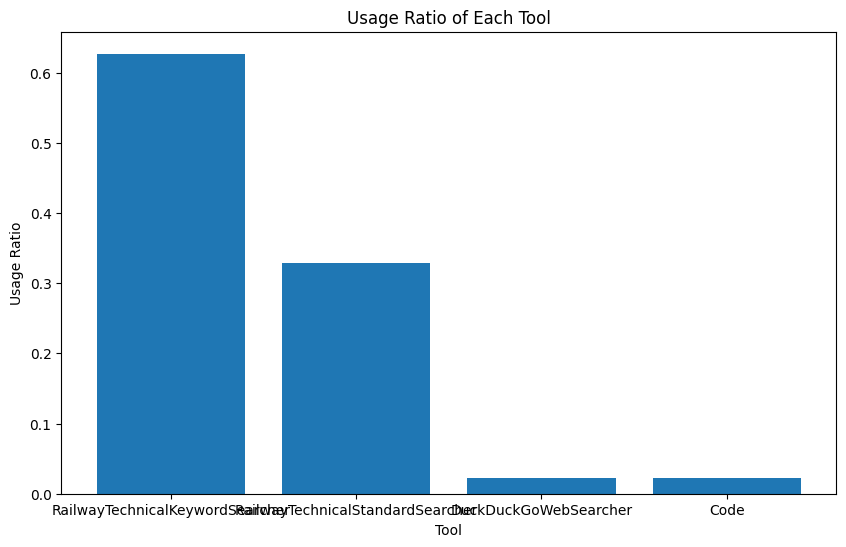

In [13]:
current_tool_usage_counts = tool_usage_tracker.get_counts()
if len(current_tool_usage_counts) > 0:
    plot_tools_count(current_tool_usage_counts)